1. Training set
    - Traing images are original and without "heavy" image processing - made in **07 Feb 2022**
    - Imbalanced distribution
2. CNN models
    - Use  full "Transfer Learning" 
        - Transfer learning 
        - Fine tune the whole CNN
    - Use basic data augmentation as recommendations of Keras
        - Rotation, translation, shift, shear, ...: Now reduce a little bit the value
    - Training metric"  
        -au_prc : area under precision-recall curve
    - Cyclic Learning rate
    - k-fold cross-validation 

In [1]:
import os
import time
import datetime

from pathlib import Path
import pandas as pd

import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
    print("tensorflow - current version:", tf.__version__)
    print("tensorflow - physical device:", tf.config.list_physical_devices())
else:
    print("The installed version of TensorFlow does not include GPU support.")

import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Model 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input

from collections import Counter
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold

import math
import matplotlib.pyplot as plt
from matplotlib import pyplot

import matplotlib.patches as mpatches

from PIL import Image

import random
import numpy as np
from numpy import where

import sys
import importlib.util

#mixed_precision.set_global_policy('float32')
policy = mixed_precision.experimental.Policy('float32')
mixed_precision.experimental.set_policy(policy)

TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
tensorflow - current version: 2.3.0
tensorflow - physical device: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


In [2]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

# Initial settings
IMG_SIZE = (128, 128)
IMG_SHAPE = (*IMG_SIZE, 3)
IMG_TYPE = 'rgb'
BATCH_SIZE = 32
COLOR_MODE = 'rgb'
MAX_EPOCHS = 500# **Settings**
1. Training set
    - Traing images are original and without image processing
    - Imbalanced distribution
2. CNN models
    - Use  full "Transfer Learning" approach with resnet50:
        - Transfer learning 
        - Fine tune the whole CNN
    - Use "class weight" as in ParticleTrieur to cope with imbalance dataset
    - Use basic data augmentation as recommendations of Keras
        - Rotation, translation, shift, shear, ...

In [3]:
# Initial settings
IMG_SIZE = (128, 128)
IMG_SHAPE = (*IMG_SIZE, 3)
IMG_TYPE = 'rgb'
BATCH_SIZE = 32
COLOR_MODE = 'rgb'
MAX_EPOCHS = 500

N_CLASSES = 29

# 1. Load train, validation and test sets from **original images**

In [4]:
filepath_train = r"C:\MyProjects\Data\Zooscan\working\data\images_20210428_142422_ImageProcess_new\ZooScan_train_WithFileName_processed.csv"
print(filepath_train)

filepath_validation = r"C:\MyProjects\Data\Zooscan\working\data\images_20210428_142422_ImageProcess_new\ZooScan_validation_WithFileName_processed.csv"
print(filepath_validation)

filepath_test = r"C:\MyProjects\Data\Zooscan\working\data\images_20210428_142422_ImageProcess_new\ZooScan_test_WithFileName_processed.csv"
print(filepath_test)

C:\MyProjects\Data\Zooscan\working\data\images_20210428_142422_ImageProcess_new\ZooScan_train_WithFileName_processed.csv
C:\MyProjects\Data\Zooscan\working\data\images_20210428_142422_ImageProcess_new\ZooScan_validation_WithFileName_processed.csv
C:\MyProjects\Data\Zooscan\working\data\images_20210428_142422_ImageProcess_new\ZooScan_test_WithFileName_processed.csv


In [5]:
X_train_df = pd.read_csv(filepath_train)
X_validation_df = pd.read_csv(filepath_validation)
X_test_df = pd.read_csv(filepath_test)

## 1.1. Merge training and validation sets for k-fold cross-validation

In [6]:
filepath_train_validation_merged = r"_Zoo_img07Feb2022-train_validation.csv"

## 1.2. Re-load merged training and validation sets

In [7]:
X_train_df = pd.read_csv(filepath_train_validation_merged)


display(X_train_df.head(5), X_train_df.shape)

display(X_train_df['filenames'][0])


,filenames,labels,short_filenames,cls
0,C:/MyProjects/Data/Zooscan/working/data/images...,aggregats_debris,0001-aggregates.png,0
1,C:/MyProjects/Data/Zooscan/working/data/images...,aggregats_debris,0002-aggregates.png,0
2,C:/MyProjects/Data/Zooscan/working/data/images...,aggregats_debris,0002.png,0
3,C:/MyProjects/Data/Zooscan/working/data/images...,aggregats_debris,0003-aggregates.png,0
4,C:/MyProjects/Data/Zooscan/working/data/images...,aggregats_debris,0004-aggregates.png,0


(58799, 4)

'C:/MyProjects/Data/Zooscan/working/data/images_20210428_142422_ImageProcess_new/train_processed//aggregats_debris/0001-aggregates.png'

# 2. Data Augmentation and Loading

In [8]:
train_gen = ImageDataGenerator(
                                dtype = "float32",
                                #rescale = 1./255.0,
                                rotation_range = 270,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                brightness_range=[0.4, 1.0],
                                #channel_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='reflect',
                                preprocessing_function = preprocess_input
                              )

validation_gen = ImageDataGenerator(
                                    dtype="float32",
                                    preprocessing_function = preprocess_input
                                    # preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
                                    #rescale=1./255.0
                                   )

# 3. Create CNN model

# 3.1. Set metrics

In [9]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

OPTIMIZER = tf.keras.optimizers.Adam()

LOSS = tf.keras.losses.CategoricalCrossentropy()



## 3.2. CNN model architecture

In [10]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, LeakyReLU,ReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization , Input ,concatenate
from tensorflow.keras.regularizers import l1,l2

In [11]:
def create_CNN_model():
    
    input_name='image'

    x = Input(shape=IMG_SHAPE, name=input_name)
    
    # Create the base model from the pre-trained model MobileNet V2
    pre_trained_model = tf.keras.applications.EfficientNetB1(input_shape=IMG_SHAPE,
                                                   include_top=False,pooling='avg',
                                                   weights='imagenet')

    # freeze the batch normalisation layers
    for layer in reversed(pre_trained_model.layers):
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True
            
    base_model = pre_trained_model(x)
    
    # 3.3. Create a classification head
    dropout_body = Dropout(0.5)(base_model)
    dense_body = layers.Dense(512, activation='relu')(dropout_body)
    classfier_layer = Dense(N_CLASSES, activation='softmax', name='classifier')(dense_body)
    
    model = Model(
                    inputs=x ,
                    outputs=classfier_layer
                    )
    return model

In [12]:
model = create_CNN_model()
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

In [13]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 1280)              6575239   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
classifier (Dense)           (None, 29)                14877     
Total params: 7,245,988
Trainable params: 7,121,885
Non-trainable params: 124,103
_________________________________________________________________


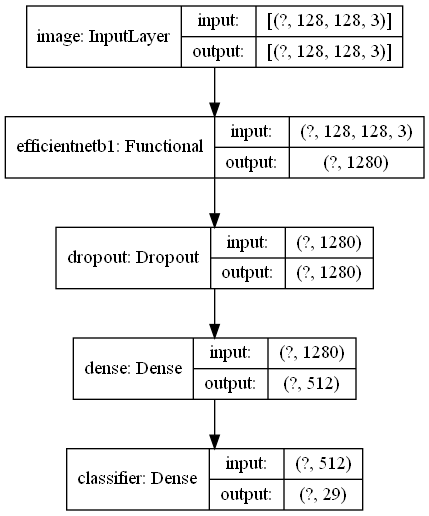

In [14]:
tf.keras.utils.plot_model(model, "_Zoo-EfficientNetB1-img07Feb22-02Mars.png", show_shapes=True)

# 4. Train Model

## 4.1. Create path to store all stuffs

In [15]:
ROOT= r"C:\MyProjects\Data\Zooscan\working\data\images_20210428_142422_ImageProcess_new\experiments\_outputs"
MODEL_NAME = "EfficientNetB1"

TAGS = ""
index="02Mars"

print("Hello! We are working with the CNN model:", MODEL_NAME)

# Setup folders

date_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

OUTPUT_DIR = f"{ROOT}"

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
    #print("The folder", OUTPUT_DIR, "has been created!")
#else:
#   print("The folder", OUTPUT_DIR, "exists!")

MODEL_DIR = f"{OUTPUT_DIR}\{MODEL_NAME}" 

if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    #print("The folder", MODEL_DIR, "has been created!")
#else:
#    print("The folder", MODEL_DIR, "exists!")

LOG_DIR = f"{MODEL_DIR}\\_Zoo-img07Feb22-exp{index}"

if not os.path.exists(LOG_DIR):
    os.mkdir(LOG_DIR)
#    print("The folder", LOG_DIR, "has been created!")
#else:
#    print("The folder", LOG_DIR, "exists!")

LOGTIME_DIR = f"{LOG_DIR}\_{TAGS}_{date_time}"

if not os.path.exists(LOGTIME_DIR):
    os.mkdir(LOGTIME_DIR)
#    print("The folder", LOGTIME_DIR, "has been created!")
#else:
#    print("The folder", LOGTIME_DIR, "exists!")

CNN_MODEL_NAME = f'{MODEL_NAME}_{date_time}'

# MODEL_FILE = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_saved.hdf5'

# HISTORY_CSV = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_History.csv'

# MODEL_CHECKPOINTS = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_best_model.hdf5'

# MODEL_TIME = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_TrainingTime.txt'
# 
MODEL_WEIGHTS_INITIAL = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_model_weights_initial.hdf5'
# MODEL_WEIGHTS_FINAL = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_model_weights_final.hdf5'
# MODEL_FINAL_EPOCH = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_model_final_epoch.hdf5'

Hello! We are working with the CNN model: EfficientNetB1


In [16]:
# serialize model to JSON (model architechture)
MODEL_ARCHITECHTURE_JSON = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_model_archJSON.json'
model_json = model.to_json()
with open(MODEL_ARCHITECHTURE_JSON, "w") as json_file:
    json_file.write(model_json)

# # save as YAML (model architechture)
# MODEL_ARCHITECHTURE_YAML = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_model_archJSON.yaml'
# model_yaml = model.to_yaml()
# with open(MODEL_ARCHITECHTURE_YAML, "w") as yaml_file:
#     yaml_file.write(model_yaml)
    
# serialize weights to HDF5 (model weights)
MODEL_WEIGHTS_INITIAL = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_model_weights_initial.hdf5'
model.save_weights(MODEL_WEIGHTS_INITIAL)

In [17]:
display(MODEL_WEIGHTS_INITIAL)
display(MODEL_ARCHITECHTURE_JSON)

'C:\\MyProjects\\Data\\Zooscan\\working\\data\\images_20210428_142422_ImageProcess_new\\experiments\\_outputs\\EfficientNetB1\\_Zoo-img07Feb22-exp02Mars\\__20220306-010544\\EfficientNetB1_20220306-010544_model_weights_initial.hdf5'

'C:\\MyProjects\\Data\\Zooscan\\working\\data\\images_20210428_142422_ImageProcess_new\\experiments\\_outputs\\EfficientNetB1\\_Zoo-img07Feb22-exp02Mars\\__20220306-010544\\EfficientNetB1_20220306-010544_model_archJSON.json'

In [18]:
layer_output = model.get_layer('classifier').get_weights()
display(layer_output)

[array([[-0.09580712, -0.00758584, -0.07261417, ..., -0.00693762,
          0.01329476, -0.07448657],
        [ 0.01419703,  0.06572335, -0.02747233, ...,  0.03466707,
         -0.06296121,  0.06566452],
        [-0.0493481 ,  0.10519207,  0.01556516, ...,  0.06625859,
         -0.05249143, -0.04166599],
        ...,
        [-0.10067896,  0.07814843,  0.02888312, ..., -0.08492288,
         -0.08282036,  0.02556727],
        [-0.03940226, -0.09691392, -0.08437846, ...,  0.00631913,
         -0.06154581, -0.10049991],
        [ 0.04618412,  0.07660221, -0.06360324, ..., -0.07507664,
          0.04013243,  0.04102273]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]

## 4.2. Find the best learning rate bound (i.e., min - max learning rate)

In [22]:
model.load_weights(MODEL_WEIGHTS_INITIAL)

In [23]:
path = os.path.abspath('..//..//learningRateFinder.py')
print(path)
spec = importlib.util.spec_from_file_location("learningRateFinder", path)
foo4 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo4)
foo4.LRFinder

C:\MyProjects\iPythonScripts\Plankton_zooscan\learningRateFinder.py


learningRateFinder.LRFinder

In [24]:
X_train, X_validation = train_test_split(
                                    X_train_df, 
                                    stratify=X_train_df["labels"], 
                                    test_size=0.25, shuffle=True
                                  )

display(X_train.head(5), X_train.shape)
display(X_validation.head(5), X_validation.shape)

,filenames,labels,short_filenames,cls
13310,C:/MyProjects/Data/Zooscan/working/data/images...,aggregats_debris,j_130317b_inf1000_tot_1_314.png,0
57378,C:/MyProjects/Data/Zooscan/working/data/images...,fiber,j_0217_120_sup1000_tot_1_539.png,19
54913,C:/MyProjects/Data/Zooscan/working/data/images...,cop_cyclopoida_oithonoida,j_0417_120_sup1000_tot_1_11.png,6
4107,C:/MyProjects/Data/Zooscan/working/data/images...,aggregats_debris,39000.png,0
35913,C:/MyProjects/Data/Zooscan/working/data/images...,crust_calyptopis,j_0217_120_inf1000_tot_1_1564.png,10


(44099, 4)

,filenames,labels,short_filenames,cls
30311,C:/MyProjects/Data/Zooscan/working/data/images...,cop_calanoida,j_0218_120_inf1000_tot_1_3346.png,5
25380,C:/MyProjects/Data/Zooscan/working/data/images...,cop_calanoida,34960.png,5
25332,C:/MyProjects/Data/Zooscan/working/data/images...,cop_calanoida,34790.png,5
29554,C:/MyProjects/Data/Zooscan/working/data/images...,cop_calanoida,j_0218_120_inf1000_tot_1_1475.png,5
58282,C:/MyProjects/Data/Zooscan/working/data/images...,tuni_appendicularia,j_0218_120_inf1000_tot_1_1926.png,26


(14700, 4)

In [25]:
data_drift_train= X_train.groupby('labels').size().to_frame('Number of Training images')
data_drift_validation = X_validation.groupby('labels').size().to_frame('Number of Validation images')
pd.concat([data_drift_train, data_drift_validation], axis=1).reset_index()

,labels,Number of Training images,Number of Validation images
0,aggregats_debris,14626,4875
1,bivalvia,152,51
2,chaetognatha,361,121
3,cnidaria_and_fragments,247,82
4,cnidaria_siphonophorae,184,61
5,cop_calanoida,14993,4998
6,cop_cyclopoida_oithonoida,2505,835
7,cop_cyclopoida_others,2023,674
8,cop_harpacticoida,724,241
9,crust_amphipoda,74,24


In [26]:
train_iter = train_gen.flow_from_dataframe(
                                            X_train,
                                            x_col = "filenames", y_col = "labels",
                                            batch_size = BATCH_SIZE,
                                            target_size = IMG_SIZE,
                                            color_mode = COLOR_MODE,
                                            class_mode = "categorical", shuffle = True
                                          )

validation_iter = validation_gen.flow_from_dataframe(
                                                    X_validation,
                                                    x_col = "filenames", y_col = "labels",
                                                    batch_size = BATCH_SIZE,
                                                    target_size = IMG_SIZE, 
                                                    color_mode = COLOR_MODE,
                                                    class_mode = "categorical", shuffle = False
                                                       )

Found 44099 validated image filenames belonging to 29 classes.
Found 14700 validated image filenames belonging to 29 classes.


In [27]:
lr_finder = foo4.LRFinder(model)
lr_finder.find(train_iter,
               validation_iter, 
               start_lr=1e-10, end_lr=1e-2, 
               # stepsPerEpoch= train_iterator.__len__(),
               # valSteps = validation_iterator.__len__(),
               # class_weight = class_weights_PT,
               epochs=5)

Epoch 1/5
1379/1379 [==============================] - 302s 219ms/step - loss: 3.2965 - tp: 0.0000e+00 - fp: 2.0000 - tn: 1234770.0000 - fn: 44099.0000 - accuracy: 0.0708 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6183 - prc: 0.0542 - val_loss: 3.2375 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 411600.0000 - val_fn: 14700.0000 - val_accuracy: 0.1007 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6327 - val_prc: 0.0701
Epoch 2/5
1379/1379 [==============================] - 299s 217ms/step - loss: 3.2659 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1234772.0000 - fn: 44099.0000 - accuracy: 0.0811 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6325 - prc: 0.0587 - val_loss: 3.0961 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 411600.0000 - val_fn: 14700.0000 - val_accuracy: 0.2054 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6993 - val_prc: 0.1318
Epoch 3/5
1379/1379 [==============================] - 298s 216ms/step - los

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (functional_1/classifier/Softmax:0) = ] [[nan nan nan...]...] [y (Cast_2/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_1/assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_greater_equal_2/Assert/AssertGuard/pivot_f/_59/_237]]
  (1) Invalid argument:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (functional_1/classifier/Softmax:0) = ] [[nan nan nan...]...] [y (Cast_2/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/else/_1/assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_30472]

Function call stack:
train_function -> train_function


In [28]:
display(len(lr_finder.losses))

min_value = min(lr_finder.losses)
print(min_value)
min_index = lr_finder.losses.index(min_value)
display(min_index)
display(lr_finder.lrs[min_index])

6401

0.7578718066215515


5516

0.00025118818

In [40]:
0.00025118818 - 2.5118818e-4

0.0

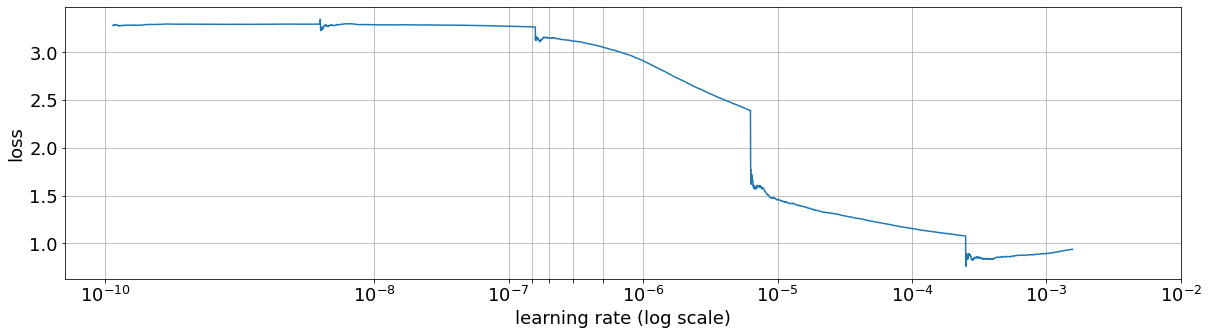

In [37]:
fig = plt.figure()
fig.set_size_inches(20,5, forward=True)
plt.rc('font', size=18)
lr_finder.plot_loss(n_skip_beginning=50, n_skip_end=200)

# ax = fig.gca()
plt.xticks([1e-10, 1e-8, 1e-7,1.5e-7,2e-7,3e-7,5e-7,1e-6,1e-5,1e-4,1e-3,1e-2])


plt.show()

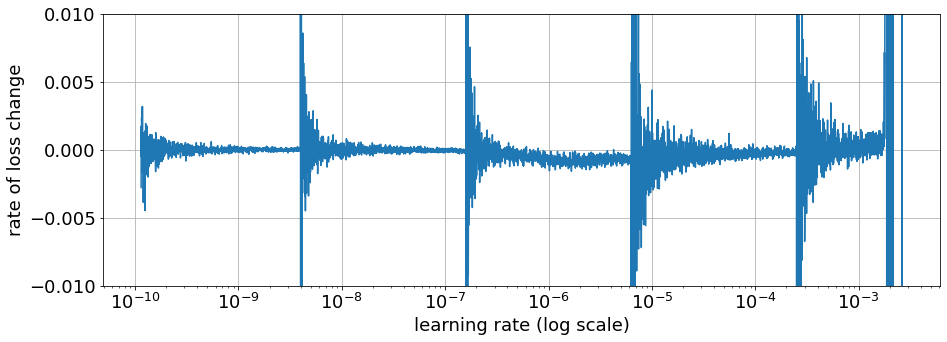

In [38]:
fig = plt.figure()
fig.set_size_inches(15,5, forward=True)
plt.rc('font', size=18)
lr_finder.plot_loss_change(n_skip_beginning=50, n_skip_end=5)
plt.show()

## 4.3. Set min-max learning rate bound

In [19]:
path = os.path.abspath('..//..//..//Plankton_Flowcam_CNN/plot_result.py')
print(path)
spec = importlib.util.spec_from_file_location("plot_result", path)
foo2 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo2)
foo2.plot_result
path = os.path.abspath('..//..//CyclicLR.py')
print(path)
spec = importlib.util.spec_from_file_location("CyclicLR", path)
foo3 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo3)
foo3.CyclicLR

# display(MODEL_TIME)
# display(MODEL_CHECKPOINTS)
# display(HISTORY_CSV)
# display(MODEL_FILE)
# display(CNN_MODEL_NAME)
# display(MODEL_WEIGHTS_INITIAL)
# display(MODEL_WEIGHTS_FINAL)



def create_Callbakcs(strBestModelName, steps_per_epoch):
# min_learningRate = 1.5e-06
# max_learningRate = 3.9810733e-05
# min_learningRate=1e-6
# max_learningRate=5e-5
    min_learningRate = 1.5e-07
    max_learningRate = 2.6e-4
    
    clr_triangular = foo3.CyclicLR(base_lr=min_learningRate, max_lr=max_learningRate,step_size=8*steps_per_epoch, mode='triangular')

    early_stopping = EarlyStopping(patience=15, monitor='val_prc', verbose=1, mode='max')
    model_checkpoint = ModelCheckpoint(filepath = strBestModelName, monitor="val_prc", save_best_only=True, verbose=1, mode='max')
    
    return [clr_triangular, early_stopping, model_checkpoint]

C:\MyProjects\iPythonScripts\Plankton_Flowcam_CNN\plot_result.py
C:\MyProjects\iPythonScripts\Plankton_zooscan\CyclicLR.py


# 4. Run k-fold cross-validation (k=5)

In [20]:
Y_train_df = X_train_df[['labels']]

display(Y_train_df.head(5), Y_train_df.shape, type(Y_train_df))

,labels
0,aggregats_debris
1,aggregats_debris
2,aggregats_debris
3,aggregats_debris
4,aggregats_debris


(58799, 1)

pandas.core.frame.DataFrame

In [21]:
skf = StratifiedKFold(n_splits = 4, random_state = 7, shuffle = True) 

display(skf)

StratifiedKFold(n_splits=4, random_state=7, shuffle=True)

In [23]:
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))

In [22]:
for train_index, val_index in skf.split(np.zeros(len(X_train_df)),Y_train_df):
    print(train_index)
    print(val_index)

[    0     2     3 ... 58792 58793 58794]
[    1     9    18 ... 58796 58797 58798]
[    0     1     4 ... 58796 58797 58798]
[    2     3    14 ... 58782 58784 58787]
[    0     1     2 ... 58796 58797 58798]
[    6    10    17 ... 58785 58786 58791]
[    1     2     3 ... 58796 58797 58798]
[    0     4     5 ... 58792 58793 58794]


In [23]:
all_history={}

fold=1

for train_index, val_index in skf.split(np.zeros(len(X_train_df)),Y_train_df):
    
    training_data = X_train_df.iloc[train_index]
    
    validation_data = X_train_df.iloc[val_index]
    
    train_iterator = train_gen.flow_from_dataframe(
                                                training_data,
                                                x_col = "filenames", y_col = "labels",
                                                batch_size = BATCH_SIZE,
                                                target_size = IMG_SIZE,
                                                color_mode = COLOR_MODE,
                                                shuffle = True
                                              )
    
    validation_iterator = validation_gen.flow_from_dataframe(
                                                        validation_data,
                                                        x_col = "filenames", y_col = "labels",
                                                        batch_size = BATCH_SIZE,
                                                        target_size = IMG_SIZE, 
                                                        color_mode = COLOR_MODE,
                                                        shuffle = False
                                                           )
    
    steps_per_epoch = train_iterator.__len__()
    
#     num_per_targetNames_train = Counter(train_iter.classes)
#     num_per_targetNames_validation = Counter(validation_iter.classes)
    
#     display(num_per_targetNames_train)
#     display(num_per_targetNames_validation)
    print("... Working at fold ", fold, "...")
    print("\t step per epoch is: ", steps_per_epoch)
    print("\t 1. Reloading initial weights of the CNN model...")
    model.load_weights(MODEL_WEIGHTS_INITIAL)
    
    print("\t 1.1. Re-compiling the CNN model...")
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    
    print("\t 2. Starting training the model...")
    start = time.time()
    
    MODEL_CHECKPOINTS = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}-best_model-fold_{fold}.hdf5'
    
    print("\t\t 2.1. Best model will be stored in the file: ", MODEL_CHECKPOINTS)
    
    history_TLearning = model.fit(
                                    train_iterator, 
                                    validation_data = validation_iterator, 
                                    epochs = MAX_EPOCHS,
                                    # class_weight=class_weights_PT,
                                    callbacks=create_Callbakcs(MODEL_CHECKPOINTS, steps_per_epoch), 
                                    verbose=1
                                    )

    time_done = time.time() - start
    
    print("\t\t 2.2. Total time for training the CNN model in fold ", fold, "is: ", time_done, "seconds")
    
    MODEL_TIME = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}-TrainingTime-fold_{fold}.txt'
    with open(MODEL_TIME, mode='w') as file:
        file.write('Total time for training the CNN model: %3f seconds.\n' %time_done)
    
    
    MODEL_WEIGHTS_FINAL = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}-model_weights_final-fold_{fold}.hdf5'
    model.save_weights(MODEL_WEIGHTS_FINAL)
    print("\t\t 2.3. Model at final epoch will be stored in the file: ", MODEL_WEIGHTS_FINAL)
    
    #save whole model at final epoch of training process
    MODEL_FINAL_EPOCH = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}-model_final_epoch-fold_{fold}.hdf5'
    model.save(MODEL_FINAL_EPOCH)
    print("\t\t 2.4. Model's weights at final epoch will be stored in the file: ", MODEL_WEIGHTS_FINAL)

    # convert the history.history dict to a pandas DataFrame
    # Save the history to CSV for further visualization
    hist_df = pd.DataFrame(history_TLearning.history.copy()) 
    
    HISTORY_CSV = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}-History-fold_{fold}.csv'
    print("\t\t 2.5. Learning curve of the model will be stored in the file: ", HISTORY_CSV)
    
    with open(HISTORY_CSV, mode='w') as f:
        hist_df.to_csv(f)
    
    print("... Ended fold ", fold, "...\n\n")
    
    all_history[f'history-fold-{fold}'] = history_TLearning
    
    
    # if fold == 1: break;
    fold +=1

Found 44099 validated image filenames belonging to 29 classes.
Found 14700 validated image filenames belonging to 29 classes.
... Working at fold  1 ...
	 step per epoch is:  1379
	 1. Reloading initial weights of the CNN model...
	 1.1. Re-compiling the CNN model...
	 2. Starting training the model...
		 2.1. Best model will be stored in the file:  C:\MyProjects\Data\Zooscan\working\data\images_20210428_142422_ImageProcess_new\experiments\_outputs\EfficientNetB1\_Zoo-img07Feb22-exp02Mars\__20220306-010544\EfficientNetB1_20220306-010544-best_model-fold_1.hdf5
Epoch 1/500
1379/1379 [==============================] - ETA: 0s - loss: 1.5552 - tp: 19461.0000 - fp: 5406.0000 - tn: 1229366.0000 - fn: 24638.0000 - accuracy: 0.5774 - precision: 0.7826 - recall: 0.4413 - auc: 0.9376 - prc: 0.6243 ET - ETA: 24s - loss: 1.6145 - tp: 17064.0000 - fp: 4872.0000 - tn: 1125964.0 - ETA: 6s - loss: 1.5700 - tp: 18852.0000 - fp: 5264.0000 - tn: 1202628.0000 - fn: 24287.0000 - accuracy: 0.5742 - pr
Epoch

# 5. Visualize results

## 5.1. Plot Training process

In [24]:
LOGTIME_DIR

'C:\\MyProjects\\Data\\Zooscan\\working\\data\\images_20210428_142422_ImageProcess_new\\experiments\\_outputs\\EfficientNetB1\\_Zoo-img07Feb22-exp02Mars\\__20220306-010544'

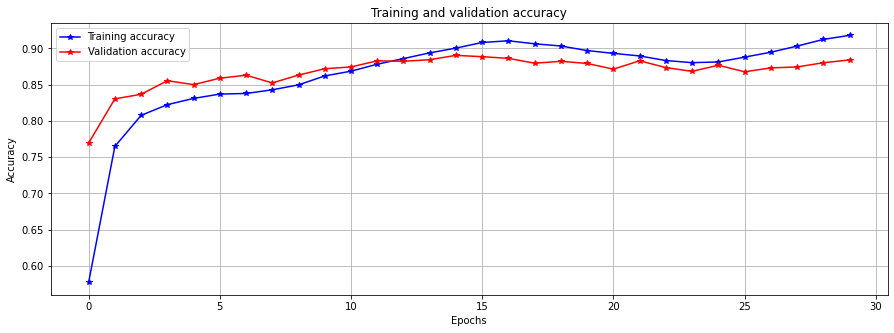

<Figure size 432x288 with 0 Axes>

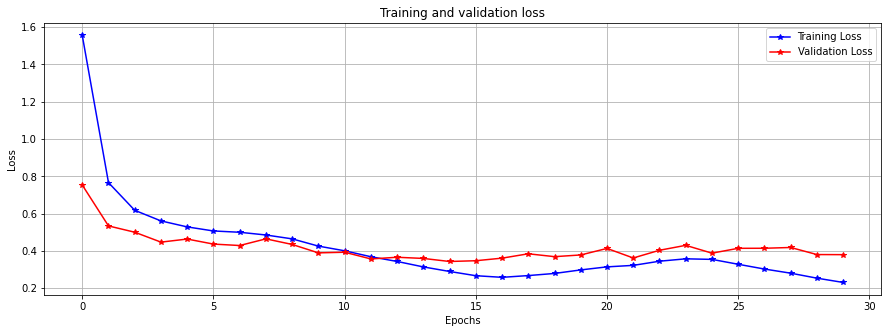

<Figure size 432x288 with 0 Axes>

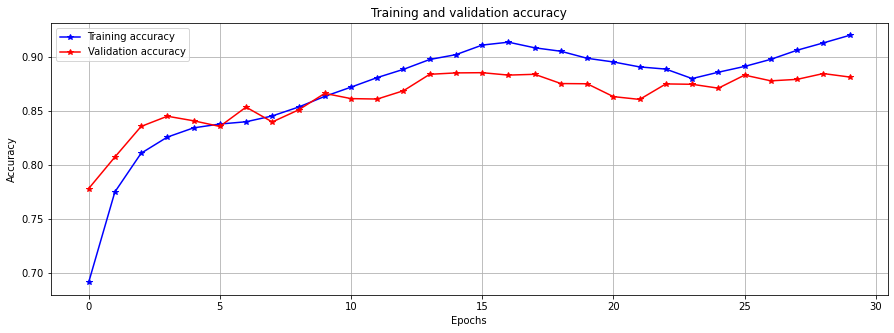

<Figure size 432x288 with 0 Axes>

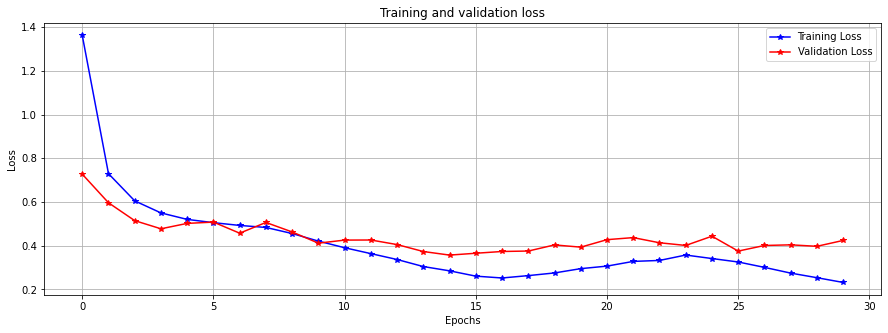

<Figure size 432x288 with 0 Axes>

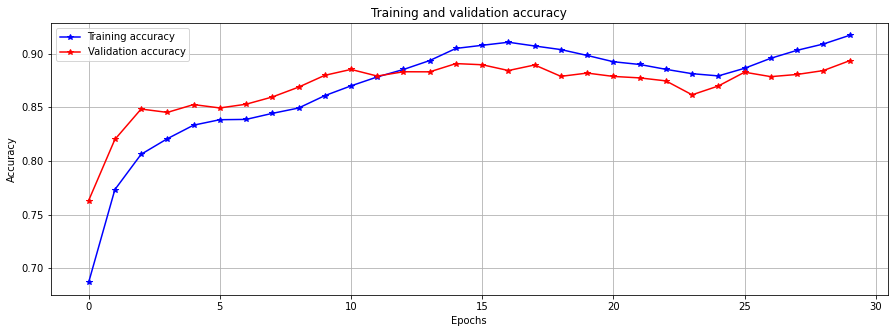

<Figure size 432x288 with 0 Axes>

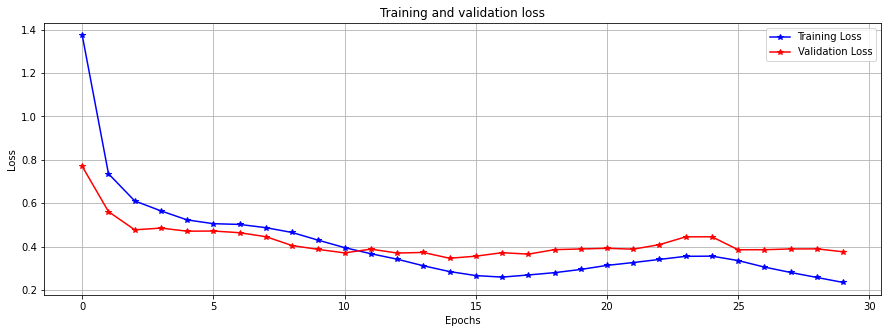

<Figure size 432x288 with 0 Axes>

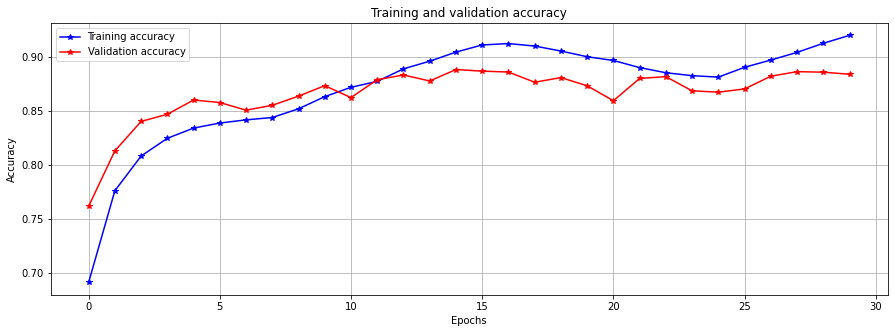

<Figure size 432x288 with 0 Axes>

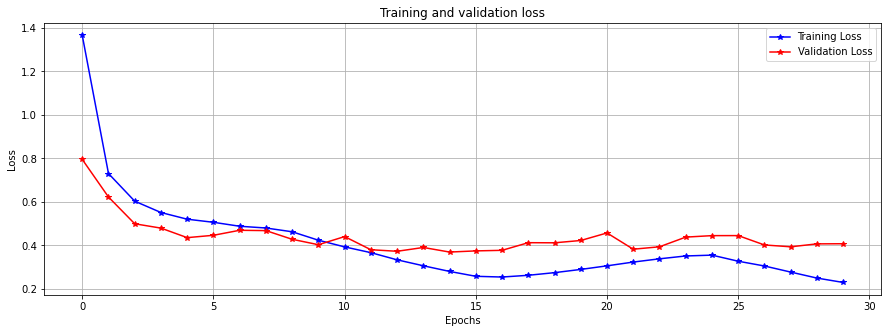

<Figure size 432x288 with 0 Axes>

In [25]:
foo2.plot_result(LOGTIME_DIR, all_history) 

In [69]:
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    plt.figure()
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.history[metric], color=colors[0], label='Train')
        plt.plot(history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
          plt.ylim([0.8,1])
        else:
          plt.ylim([0,1])

    plt.legend()
    
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [26]:
def plot_metrics_v2(folder, history, index):
    metrics = ['accuracy', 'loss', 'prc', 'precision', 'recall']
    plt.figure(figsize=(15, 15))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        
        metric_train = history.history[metric].copy()
        metric_val = history.history['val_'+ metric].copy()
        epochs = range(len(metric_train))
        
        fig = plt.figure()
        plt.rc('font', size=48)
        fig.set_size_inches(20, 20, forward=True)
        # plt.subplot(3,2,n+1)
        plt.plot(epochs, metric_train, 'b*-', label='Training ' + metric, linewidth=7.0, markersize=18)
        plt.plot(epochs, metric_val, 'r*-', label='Validation ' + metric, linewidth=7.0, markersize=18)
        plt.grid()
        
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
        if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
          plt.ylim([0.8,1])
        else:
          plt.ylim([0,1])
        
        plt.legend()
        
        plt.savefig(f'{folder}/new-fold-{index+1}-new-{metric}.png',bbox_inches="tight")      
        plt.show()

        plt.figure()
    # loss = all_history[history].history['loss'].copy()
    # val_loss = all_history[history].history['val_loss'].copy()
    # plt.plot(epochs, loss, 'b*-', label='Training Loss')
    # plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
    # plt.grid()
    # plt.title('Training and validation loss')
    # plt.ylabel("Loss")
    # plt.xlabel("Epochs")
    # plt.legend()
    # plt.savefig(f'{folder}/fold-{index+1}-loss.png')
    # plt.figure()
    # plt.show()

# 6. Evaluate Model

## 6.1. Load the best model

In [27]:
MODEL_CHECKPOINTS

'C:\\MyProjects\\Data\\Zooscan\\working\\data\\images_20210428_142422_ImageProcess_new\\experiments\\_outputs\\EfficientNetB1\\_Zoo-img07Feb22-exp02Mars\\__20220306-010544\\EfficientNetB1_20220306-010544-best_model-fold_4.hdf5'

In [28]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

In [29]:
path = os.path.abspath('..//..//plotConfusionMatrix.py')
print(path)
spec = importlib.util.spec_from_file_location("plot_confusion_matrix", path)
foo5 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo5)
foo5.plot_confusion_matrix

C:\MyProjects\iPythonScripts\Plankton_zooscan\plotConfusionMatrix.py


<function plot_confusion_matrix.plot_confusion_matrix(cm, classes, num_images_per_class, normalize=False, title='Confusion matrix', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x0000019696A4D3D0>)>

In [30]:
LOGTIME_DIR

'C:\\MyProjects\\Data\\Zooscan\\working\\data\\images_20210428_142422_ImageProcess_new\\experiments\\_outputs\\EfficientNetB1\\_Zoo-img07Feb22-exp02Mars\\__20220306-010544'

In [31]:
CNN_MODEL_NAME

'EfficientNetB1_20220306-010544'

In [32]:
for fold in range(1,5):
    display(fold)

1

2

3

4

In [99]:
from sklearn.metrics import balanced_accuracy_score, jaccard_score, average_precision_score, accuracy_score, recall_score

def calc_ClassBalancedAccuracy(confusion_matrix, classes_values, class_names): 
    result=0
    class_number = len(class_names)
    for i in classes_values:
        result += confusion_matrix[i][i] / max(sum(confusion_matrix[i,0:]), sum(confusion_matrix[0:,i]))

    result /= class_number
    
    return result


def computeGeometricAverageOfRecall(test_true, test_pred):
    result = 1.0
    for label in np.unique(test_true):
        idx = (test_true==label)
        result *= accuracy_score(np.array(test_true)[idx],np.array(test_pred)[idx])

    result = np.power(result, 1/len(np.unique(test_true)))

    return result

In [ ]:
calc_ClassBalancedAccuracy(confusion_mtx, list(test_iterator.class_indices.values()), targetNames)

In [87]:
class_names = list(test_iterator.class_indices.values())

display(class_names)
class_number = len(class_names)
display(class_number)

display(targetNames)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28]

29

['aggregats_debris',
 'bivalvia',
 'chaetognatha',
 'cnidaria_and_fragments',
 'cnidaria_siphonophorae',
 'cop_calanoida',
 'cop_cyclopoida_oithonoida',
 'cop_cyclopoida_others',
 'cop_harpacticoida',
 'crust_amphipoda',
 'crust_calyptopis',
 'crust_cirripedia_larvae',
 'crust_cladocera',
 'crust_crustacea',
 'crust_evadne_pseudevadne',
 'crust_ostracoda',
 'crust_penilia',
 'crust_podon',
 'echinodermata_larvae',
 'fiber',
 'fish_eggs',
 'fish_larvae',
 'nauplii',
 'polychaeta',
 'pter_cavolinidae',
 'pter_limacinidae',
 'tuni_appendicularia',
 'tuni_appendicularia_tail',
 'tuni_doliolida_salpida']

In [98]:
result=0
for i in class_names:
    print(i)
    result += ((confusion_mtx[i][i]) / (max(sum(confusion_mtx[i,0:]), sum(confusion_mtx[0:,i]))))

result /= class_number

display(result)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


0.6806145062344554

Confusion matrix, without normalization


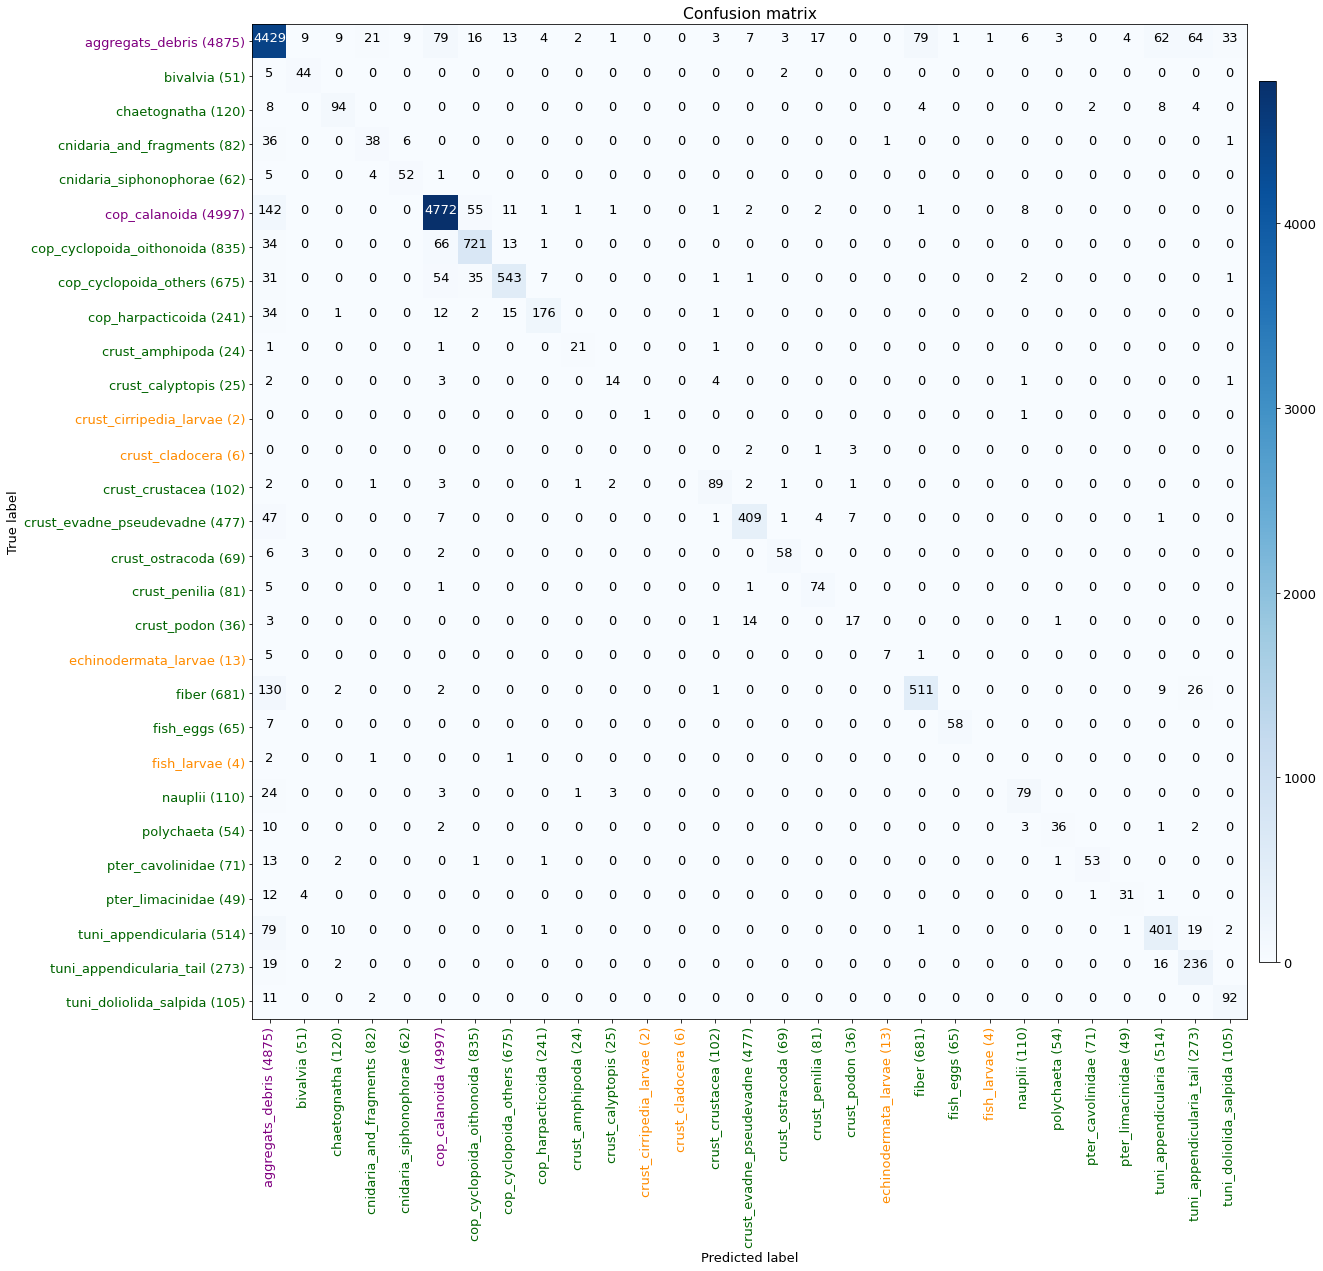

In [91]:
fig = plt.figure()
plt.rc('font', size=13)
fig.set_size_inches(20, 20, forward=True)
foo5.plot_confusion_matrix(confusion_mtx, classes = targetNames, num_images_per_class = num_per_targetNames, normalize=False) 

In [97]:
i=2

display(confusion_mtx[i][i])
display(sum(confusion_mtx[i,0:])-confusion_mtx[i][i])
display(sum(confusion_mtx[0:,i])-confusion_mtx[i][i])

display((confusion_mtx[i][i]) / max(sum(confusion_mtx[i,0:]), sum(confusion_mtx[0:,i])))

94

26

26

0.7833333333333333

In [74]:
i=0

display(confusion_mtx[i][i])
display(sum(confusion_mtx[i,1:]))
display(sum(confusion_mtx[1:,i]))

4429

446

673

In [ ]:
confusion_matrix[i][i]

Found 14700 validated image filenames belonging to 29 classes.
Counter({5: 4998, 0: 4876, 6: 835, 19: 681, 7: 674, 26: 514, 14: 478, 27: 273, 8: 242, 2: 121, 22: 111, 28: 105, 13: 101, 3: 82, 16: 80, 24: 72, 15: 69, 20: 65, 4: 61, 23: 53, 1: 50, 25: 49, 17: 37, 9: 24, 10: 24, 18: 13, 12: 6, 11: 3, 21: 3})
['aggregats_debris', 'bivalvia', 'chaetognatha', 'cnidaria_and_fragments', 'cnidaria_siphonophorae', 'cop_calanoida', 'cop_cyclopoida_oithonoida', 'cop_cyclopoida_others', 'cop_harpacticoida', 'crust_amphipoda', 'crust_calyptopis', 'crust_cirripedia_larvae', 'crust_cladocera', 'crust_crustacea', 'crust_evadne_pseudevadne', 'crust_ostracoda', 'crust_penilia', 'crust_podon', 'echinodermata_larvae', 'fiber', 'fish_eggs', 'fish_larvae', 'nauplii', 'polychaeta', 'pter_cavolinidae', 'pter_limacinidae', 'tuni_appendicularia', 'tuni_appendicularia_tail', 'tuni_doliolida_salpida']
                           precision    recall  f1-score   support

         aggregats_debris       0.86      0.93

C:\Users\Le Duong Quoc\anaconda3\envs\tf23-py38-cudnn76-cuda101\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Le Duong Quoc\anaconda3\envs\tf23-py38-cudnn76-cuda101\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Le Duong Quoc\anaconda3\envs\tf23-py38-cudnn76-cuda101\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Found 14700 validated image filenames belonging to 29 classes.
Counter({5: 4998, 0: 4875, 6: 835, 19: 681, 7: 674, 26: 513, 14: 477, 27: 273, 8: 241, 2: 121, 22: 111, 28: 106, 13: 102, 3: 82, 16: 80, 24: 72, 15: 70, 20: 64, 4: 61, 23: 53, 1: 51, 25: 49, 17: 37, 9: 25, 10: 24, 18: 13, 12: 5, 21: 4, 11: 3})
['aggregats_debris', 'bivalvia', 'chaetognatha', 'cnidaria_and_fragments', 'cnidaria_siphonophorae', 'cop_calanoida', 'cop_cyclopoida_oithonoida', 'cop_cyclopoida_others', 'cop_harpacticoida', 'crust_amphipoda', 'crust_calyptopis', 'crust_cirripedia_larvae', 'crust_cladocera', 'crust_crustacea', 'crust_evadne_pseudevadne', 'crust_ostracoda', 'crust_penilia', 'crust_podon', 'echinodermata_larvae', 'fiber', 'fish_eggs', 'fish_larvae', 'nauplii', 'polychaeta', 'pter_cavolinidae', 'pter_limacinidae', 'tuni_appendicularia', 'tuni_appendicularia_tail', 'tuni_doliolida_salpida']
                           precision    recall  f1-score   support

         aggregats_debris       0.87      0.90

C:\Users\Le Duong Quoc\anaconda3\envs\tf23-py38-cudnn76-cuda101\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Le Duong Quoc\anaconda3\envs\tf23-py38-cudnn76-cuda101\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Le Duong Quoc\anaconda3\envs\tf23-py38-cudnn76-cuda101\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Found 14699 validated image filenames belonging to 29 classes.
Counter({5: 4997, 0: 4875, 6: 835, 19: 681, 7: 675, 26: 514, 14: 477, 27: 273, 8: 241, 2: 120, 22: 110, 28: 105, 13: 102, 3: 82, 16: 81, 24: 71, 15: 69, 20: 65, 4: 62, 23: 54, 1: 51, 25: 49, 17: 36, 10: 25, 9: 24, 18: 13, 12: 6, 21: 4, 11: 2})
['aggregats_debris', 'bivalvia', 'chaetognatha', 'cnidaria_and_fragments', 'cnidaria_siphonophorae', 'cop_calanoida', 'cop_cyclopoida_oithonoida', 'cop_cyclopoida_others', 'cop_harpacticoida', 'crust_amphipoda', 'crust_calyptopis', 'crust_cirripedia_larvae', 'crust_cladocera', 'crust_crustacea', 'crust_evadne_pseudevadne', 'crust_ostracoda', 'crust_penilia', 'crust_podon', 'echinodermata_larvae', 'fiber', 'fish_eggs', 'fish_larvae', 'nauplii', 'polychaeta', 'pter_cavolinidae', 'pter_limacinidae', 'tuni_appendicularia', 'tuni_appendicularia_tail', 'tuni_doliolida_salpida']
                           precision    recall  f1-score   support

         aggregats_debris       0.87      0.91

C:\Users\Le Duong Quoc\anaconda3\envs\tf23-py38-cudnn76-cuda101\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Le Duong Quoc\anaconda3\envs\tf23-py38-cudnn76-cuda101\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Le Duong Quoc\anaconda3\envs\tf23-py38-cudnn76-cuda101\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

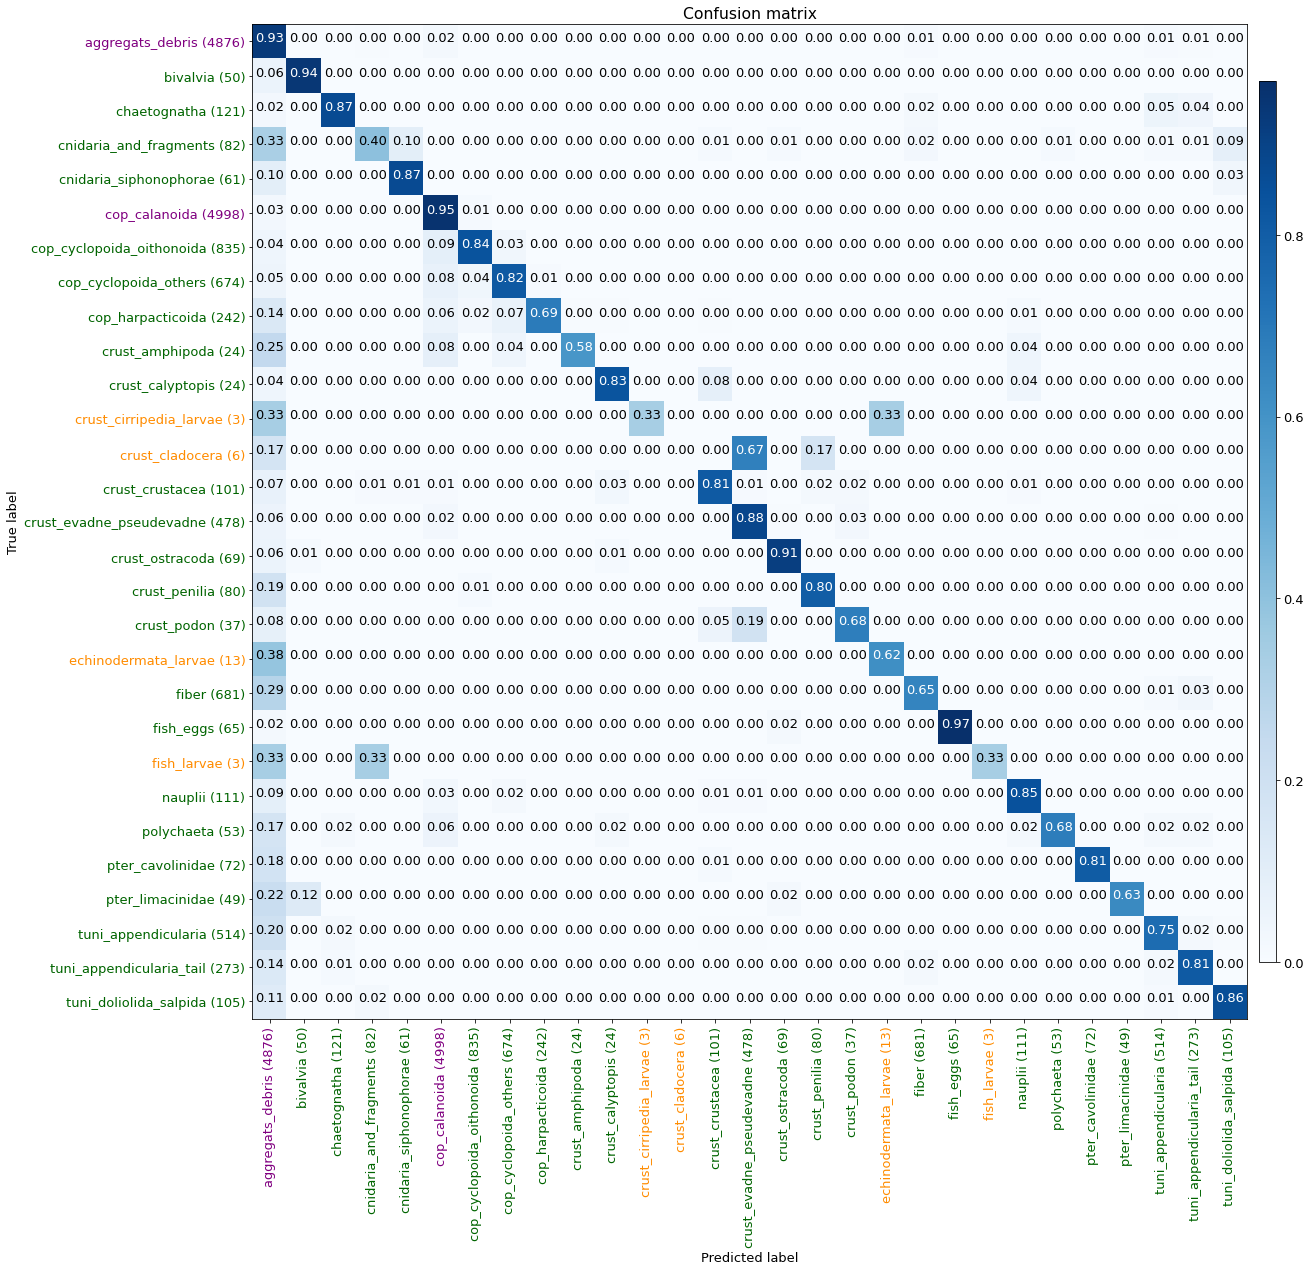

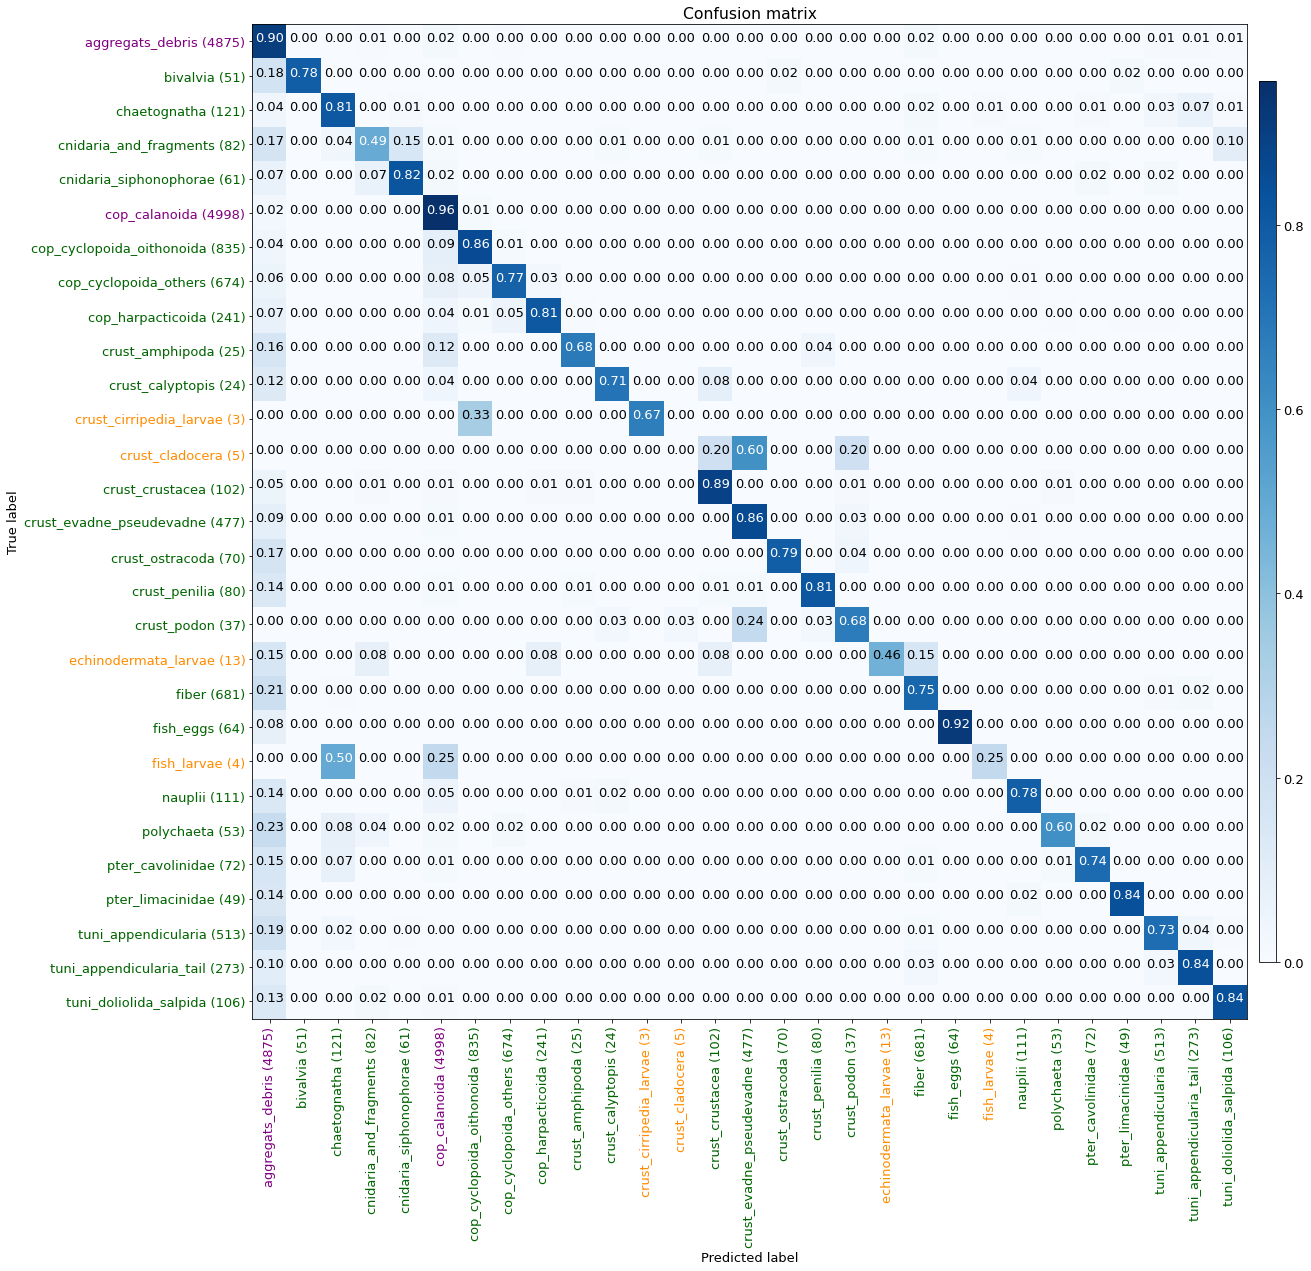

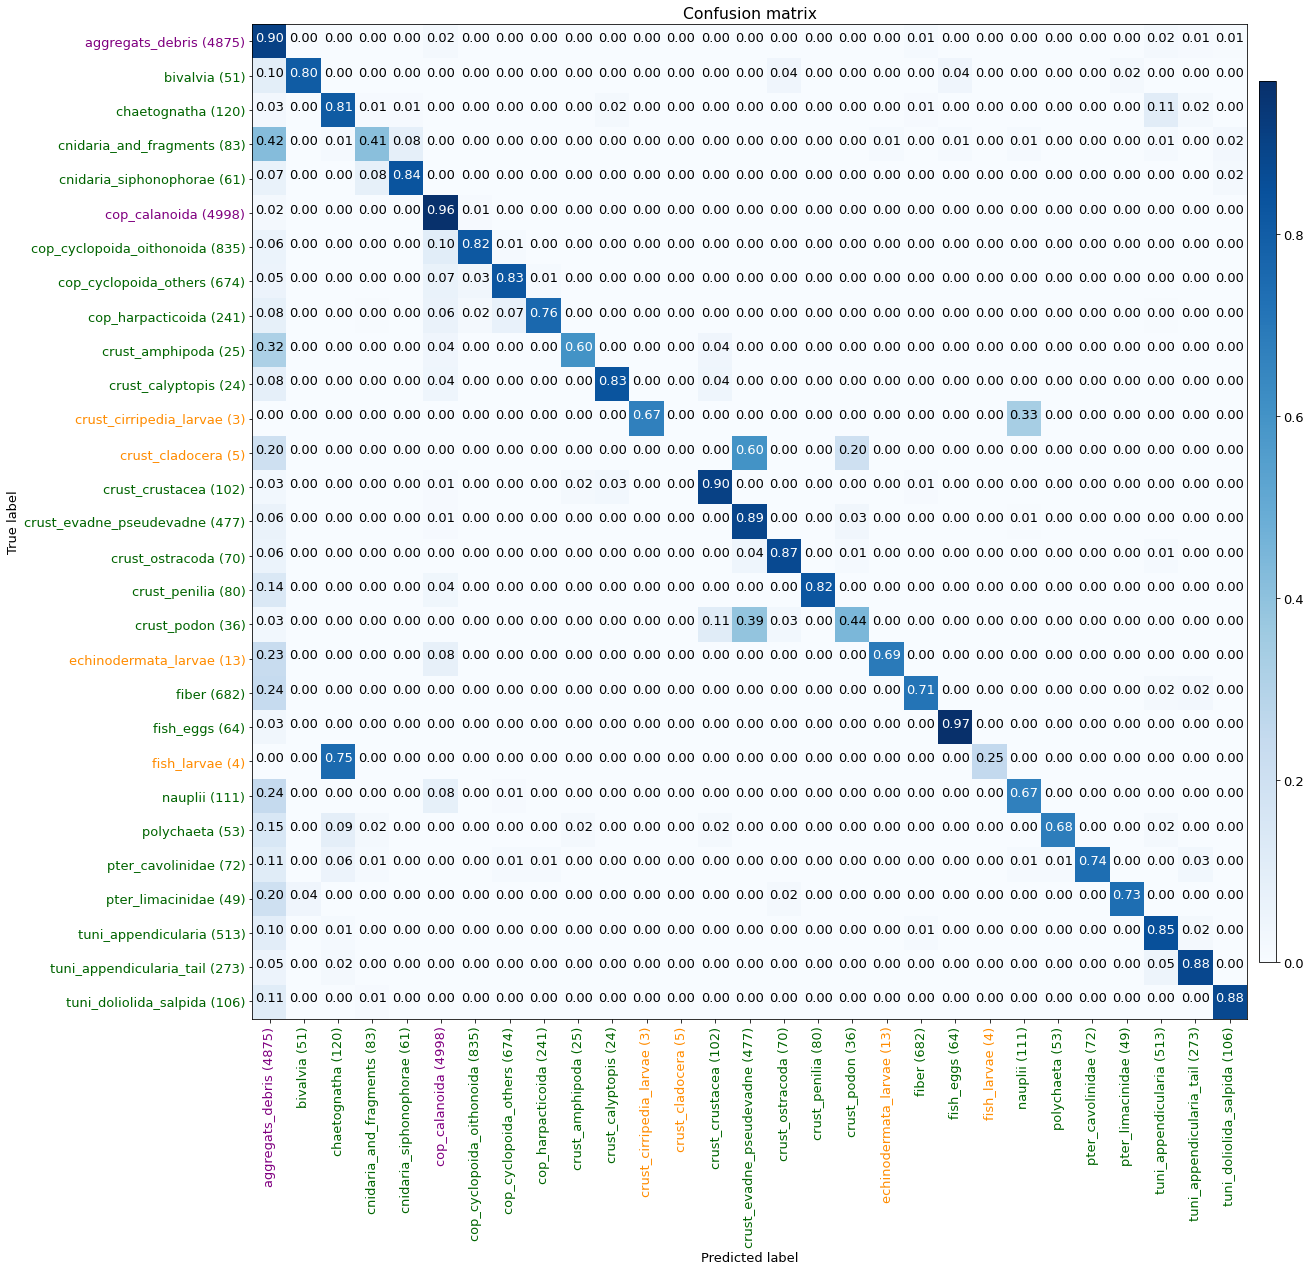

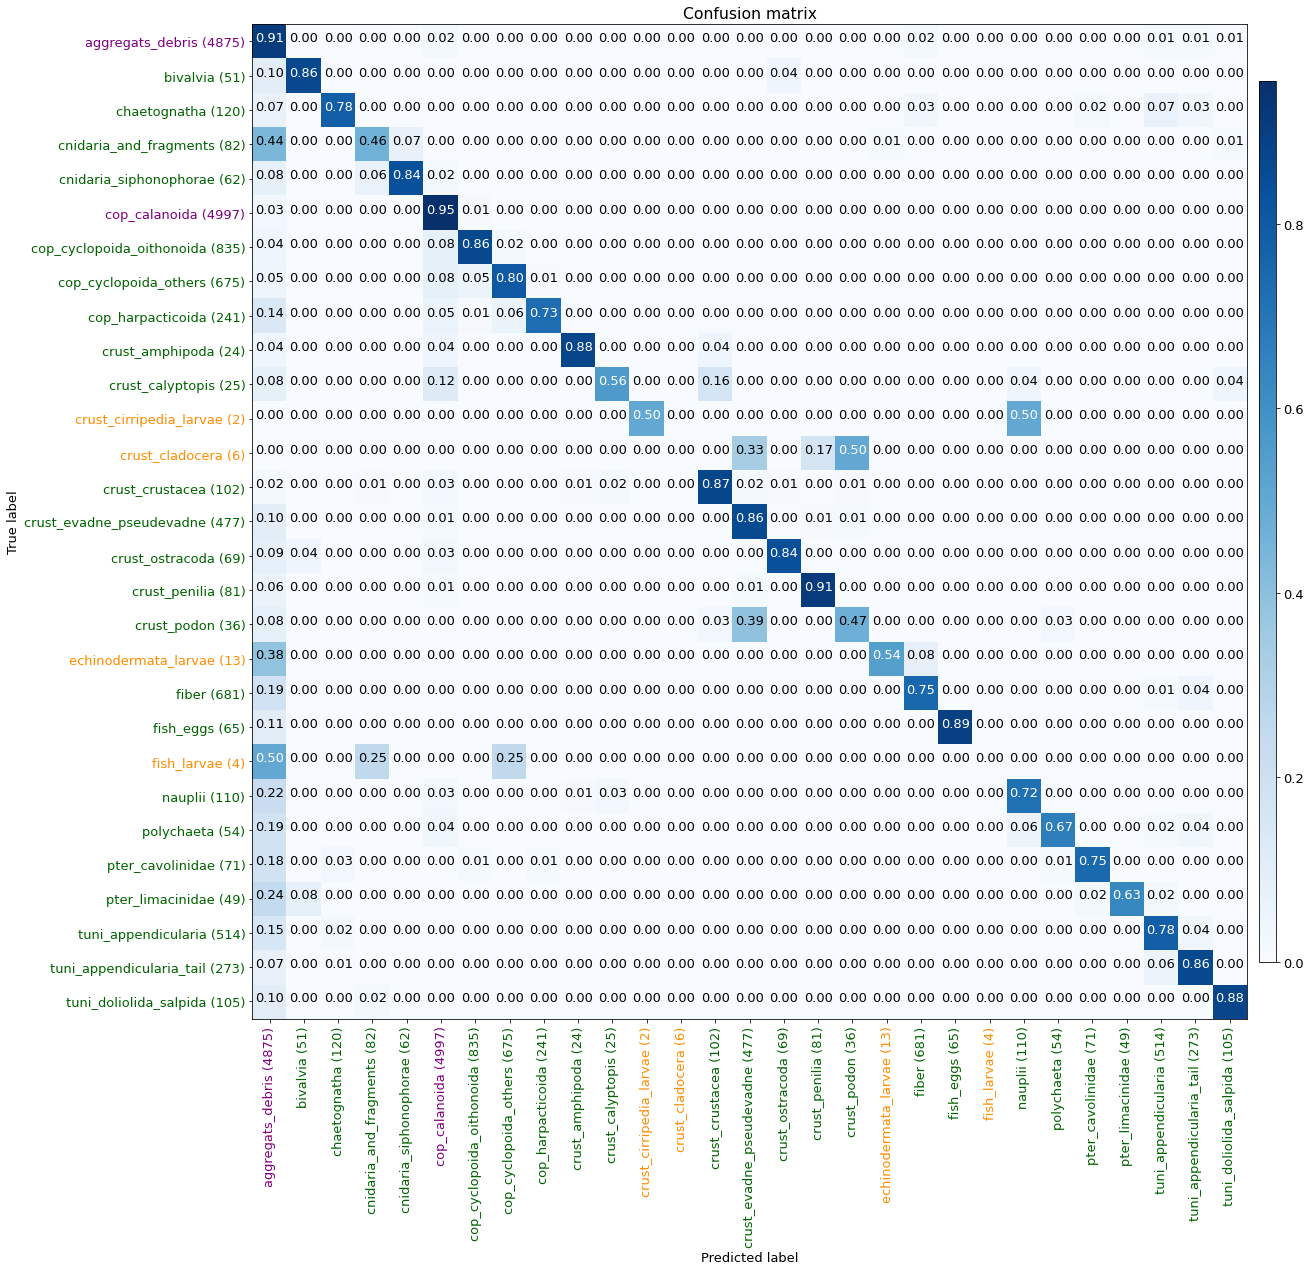

In [100]:
GMeanRecalls=[]
AverageAccuracies=[]
ClassBalanceAccuracies=[]

fold = 1

for train_index, val_index in skf.split(np.zeros(len(X_train_df)),Y_train_df):
    
    model_filename = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}-best_model-fold_{fold}.hdf5'
       
    model = tf.keras.models.load_model(
                                        model_filename,
                                       compile=False
                                        )
    
    # test_iterator = validation_gen.flow_from_dataframe(
    #                                                     X_test_df,
    #                                                     x_col = "filenames", y_col = "labels",
    #                                                     batch_size = 1,
    #                                                     target_size = IMG_SIZE, 
    #                                                     color_mode = COLOR_MODE,
    #                                                     shuffle = False
    #                                                        )
    
    validation_data = X_train_df.iloc[val_index]
    
    test_iterator = validation_gen.flow_from_dataframe(
                                                    validation_data,
                                                    x_col = "filenames", y_col = "labels",
                                                    batch_size = BATCH_SIZE,
                                                    target_size = IMG_SIZE, 
                                                    color_mode = COLOR_MODE,
                                                    class_mode = "categorical", shuffle = False
                                                       )
    
    test_prob=model.predict(test_iterator)
    test_pred = test_prob.argmax(axis=1).tolist()
    test_true = test_iterator.classes

    num_per_targetNames = Counter(test_iterator.classes)
    print(num_per_targetNames)
    targetNames=list(test_iterator.class_indices.keys())
    print(targetNames)
    
    # Accuracy, Precision, Recall, F1 score
    print(classification_report(test_true, test_pred, target_names=targetNames), sep='')
    
    REPORT_filename = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}-classification_report-validation_set-fold_{fold}.csv'
    df_classification_report = pd.DataFrame(classification_report(test_true, test_pred, target_names=targetNames, digits=2, output_dict=True)).transpose()
    df_classification_report.to_csv(REPORT_filename)
    
    
    # Confusion matrix
    confusion_mtx = confusion_matrix(test_true, test_pred) 
    
    confusionmatrix_filename = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}-confusion_matrix-validation_set-fold_{fold}.png'
    fig = plt.figure()
    plt.rc('font', size=13)
    fig.set_size_inches(20, 20, forward=True)
    foo5.plot_confusion_matrix(confusion_mtx, classes = targetNames, num_images_per_class = num_per_targetNames, normalize=True) 
    plt.savefig(confusionmatrix_filename,bbox_inches="tight")
    
       
    #average accuracy
    AverageAccuracies.append(accuracy_score(test_true,test_pred))
    
    # geometric average of recall
    GMeanRecalls.append(computeGeometricAverageOfRecall(test_true, test_pred))
    
    # class balance accuracy
    ClassBalanceAccuracies.append(calc_ClassBalancedAccuracy(confusion_mtx, list(test_iterator.class_indices.values()), targetNames))
    
    fold += 1

In [108]:
display(GMeanRecalls, AverageAccuracies, ClassBalanceAccuracies)

keys = ['fold 1', 'fold 2', 'fold 3', 'fold 4',]

vals = np.array([GMeanRecalls, AverageAccuracies, ClassBalanceAccuracies])

score_dict = dict(zip(keys, zip(*vals)))

display(score_dict)

z = {'Evaluation_scores':("Geometric_Average_of_Recalls","Average_Accuracy", "Class_Balance_Accuracy"), **score_dict}

display(z)

display(pd.DataFrame.from_dict(z))

EVALUATION_SCORE_filename = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}-evaluation_scores.csv'
pd.DataFrame.from_dict(z).to_csv(EVALUATION_SCORE_filename, index=None)

[0.0, 0.0, 0.0, 0.0]

[0.8904761904761904,
 0.8848979591836734,
 0.8907482993197279,
 0.8882236886863052]

[0.6985872931226589,
 0.6918665477552877,
 0.7017371840937122,
 0.6806145062344554]

{'fold 1': (0.0, 0.8904761904761904, 0.6985872931226589),
 'fold 2': (0.0, 0.8848979591836734, 0.6918665477552877),
 'fold 3': (0.0, 0.8907482993197279, 0.7017371840937122),
 'fold 4': (0.0, 0.8882236886863052, 0.6806145062344554)}

{'Evaluation_scores': ('Geometric_Average_of_Recalls',
  'Average_Accuracy',
  'Class_Balance_Accuracy'),
 'fold 1': (0.0, 0.8904761904761904, 0.6985872931226589),
 'fold 2': (0.0, 0.8848979591836734, 0.6918665477552877),
 'fold 3': (0.0, 0.8907482993197279, 0.7017371840937122),
 'fold 4': (0.0, 0.8882236886863052, 0.6806145062344554)}

,Evaluation_scores,fold 1,fold 2,fold 3,fold 4
0,Geometric_Average_of_Recalls,0.000000,0.000000,0.000000,0.000000
1,Average_Accuracy,0.890476,0.884898,0.890748,0.888224
2,Class_Balance_Accuracy,0.698587,0.691867,0.701737,0.680615


# 3. Customize ImageDataGenerator()

In [ ]:
train_gen = ImageDataGenerator(
                                dtype = "float32",
                                #rescale = 1./255.0,
                                rotation_range = 270,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                brightness_range=[0.4, 1.0],
                                #channel_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode='reflect',
                                # preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
                              )

validation_gen = ImageDataGenerator(
                                    dtype="float32",
                                    # preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
                                    #rescale=1./255.0
                                   )


# 4. Create model CNN + SIFT

In [ ]:
# We take the ceiling because we do not drop the remainder of the batch

compute_steps_per_epoch = lambda x: int(math.floor(x / BATCH_SIZE))

steps_per_epoch = compute_steps_per_epoch(len(X_train_df))

val_steps = compute_steps_per_epoch(len(X_validation_df))

print(steps_per_epoch)
print(val_steps)

n_classes = len(X_validation_df['labels'].unique())
print(n_classes)

In [ ]:
# feature_input_1 = Input(shape=(X_SIFT_train_df.shape[1]-1), name="SIFT") 
# feature_input_2 = Input(shape=(X_HOG_train_df.shape[1]-1), name="HOG") 
# feature_input_3 = Input(shape=(X_Global_train_df.shape[1]-1), name="GlobalFeatures") 
# feature_input_4 = Input(shape=(X_GLCM_train_df.shape[1]-1), name="GLCM") 
# feature_input_5 = Input(shape=(X_ILBP81_train_df.shape[1]-1), name="LBP") 
# feature_input_6 = Input(shape=(X_Gabor_train_df.shape[1]-1), name="Gabor") 

# feature_input = concatenate([feature_input, feature_input_2, feature_input_3, feature_input_4, feature_input_5, feature_input_6])

# total_dim = X_SIFT_train_df.shape[1]-1 + X_HOG_train_df.shape[1]-1 + X_GLCM_train_df.shape[1]-1 + X_ILBP81_train_df.shape[1]-1 + X_Gabor_train_df.shape[1]-1

# total_dim = X_SIFT_train_df.shape[1]-1 + X_HOG_train_df.shape[1]-1 + X_Global_train_df.shape[1]-1 + X_GLCM_train_df.shape[1]-1 + X_ILBP81_train_df.shape[1]-1 + X_Gabor_train_df.shape[1]-1
# total_dim= X_features_train_df.shape[1]-1
total_dim= 100
feature_input_HOG = Input(shape=(total_dim), name="HOG") 

dense_body = Dense(total_dim,name="feature_body")(feature_input_HOG)
batch_norm_body = BatchNormalization()(dense_body)
# activation_body = LeakyReLU(alpha=0.25)(batch_norm_body)
activation_body = Activation('relu')(batch_norm_body)
feature_out_HOG = Dropout(0.5)(activation_body)


In [ ]:
total_dim= 71

feature_input_LBP = Input(shape=(total_dim), name="LBP") 

dense_body_LBP = Dense(total_dim,name="feature_body_LBP")(feature_input_LBP)
batch_norm_body_LBP = BatchNormalization()(dense_body_LBP)
# activation_body = LeakyReLU(alpha=0.25)(batch_norm_body)
activation_body_LBP = Activation('relu')(batch_norm_body_LBP)
feature_out_LBP = Dropout(0.5)(activation_body_LBP)

In [ ]:
input_imageshape=(128, 128, 3)
input_name='image'

x = Input(shape=input_imageshape, name=input_name)
    
pre_trained_model = EfficientNetB1(input_shape=input_imageshape,
                                include_top=False, 
                                pooling='avg',
                                weights='imagenet')

# freeze the batch normalisation layers
for layer in reversed(pre_trained_model.layers):
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

feature_extractor = pre_trained_model(x)

In [ ]:
MergeModel = concatenate([feature_out_HOG,feature_out_LBP, feature_extractor])

dropout_body = Dropout(0.5)(MergeModel)
dense_body = layers.Dense(512, activation='relu')(dropout_body)
#x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(n_classes, activation='softmax', name='classifier')(dense_body)

In [ ]:
model = Model(inputs=[feature_input_HOG, 
                      feature_input_LBP,
                      x], 
              outputs=prediction_layer)

In [ ]:
tf.keras.utils.plot_model(model, "Zooscan-EffB1-Size128-Metric_valAUPRC-NormWeight-FocalLoss-Features_OriImages-ver10-dense_separateHOGLBP.png", show_shapes=True)

### 4.1. Set metrics

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


### 4.2. Create class weights

In [ ]:
# merge train and validation sets
X_train_validation_df = pd.concat([X_train_df, X_validation_df])

classes = X_train_validation_df.groupby('labels').size().to_frame('number of images').reset_index()


In [ ]:
from scipy.stats.mstats import gmean
count = classes['number of images'].values
# display(count)

weights_PT = gmean(count) / count
#print(weights_PT)

weights_PT[weights_PT < 0.1] = 0.1
weights_PT[weights_PT > 10] = 10
#print(weights_PT)

class_weights_PT = dict(enumerate(weights_PT))
display(class_weights_PT)

vals_weights = np.fromiter(class_weights_PT.values(), dtype=np.float32)
display(vals_weights)

### 4.3. Create Focal Loss function

In [ ]:
class categorical_focal_loss:                             
    '''
    Softmax version of focal loss.

           m
      FL = sum  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1

      where m = number of classes, c = class and o = observation

    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)

    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper

    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy

    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    '''
    def __init__(self, gamma=2., alpha=.25):
        self._gamma = gamma
        self._alpha = np.array(alpha, dtype=np.float32)
        self.__name__ = 'categorical_focal_loss'
        
    def __int_shape(self, x):
        return tf.keras.backend.int_shape(x) if self.backend == 'tensorflow' else tf.keras.backend.shape(x)    
    
    def  __call__(self, y_true, y_pred):        
        '''
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        '''

        # Scale predictions so that the class probas of each sample sum to 1
#         y_pred /= tf.keras.backend.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * tf.keras.backend.log(y_pred)

        # Calculate Focal Loss
        loss = self._alpha * tf.keras.backend.pow(1 - y_pred, self._gamma) * cross_entropy

        # Sum the losses in mini_batch
        return tf.keras.backend.sum(loss, axis=1)

### 4.4. make model

In [ ]:
c

# 5. Let's train the mode

## 5.1. Create path to store all stuffs

In [ ]:
ROOT= r"C:\Users\HiHi-Ledvic\Documents\MyProjects\experiments\_outputs\images_20210428_142422_ImageProcess_new"
MODEL_NAME = "EffB1"

TAGS = "HOG_LBPH"
index=2

print("Hello! We are working with the CNN model:", MODEL_NAME)

# Setup folders

date_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

OUTPUT_DIR = f"{ROOT}\data_resize_square"

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
    #print("The folder", OUTPUT_DIR, "has been created!")
#else:
#   print("The folder", OUTPUT_DIR, "exists!")

MODEL_DIR = f"{OUTPUT_DIR}\{MODEL_NAME}" 

if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    #print("The folder", MODEL_DIR, "has been created!")
#else:
#    print("The folder", MODEL_DIR, "exists!")

LOG_DIR = f"{MODEL_DIR}\\B1_focal_normweight_valAUPRC_Features-exp{index}"

if not os.path.exists(LOG_DIR):
    os.mkdir(LOG_DIR)
#    print("The folder", LOG_DIR, "has been created!")
#else:
#    print("The folder", LOG_DIR, "exists!")

LOGTIME_DIR = f"{LOG_DIR}\_{TAGS}_{date_time}"

if not os.path.exists(LOGTIME_DIR):
    os.mkdir(LOGTIME_DIR)
#    print("The folder", LOGTIME_DIR, "has been created!")
#else:
#    print("The folder", LOGTIME_DIR, "exists!")

CNN_MODEL_NAME = f'{MODEL_NAME}_{date_time}'

MODEL_FILE = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_saved.hdf5'

HISTORY_CSV = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_History.csv'

MODEL_CHECKPOINTS = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_best_model.hdf5'

MODEL_TIME = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_TrainingTime.txt'

MODEL_WEIGHTS_INITIAL = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_model_weights_initial.hdf5'
MODEL_WEIGHTS_FINAL = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_model_weights_final.hdf5'
MODEL_FINAL_EPOCH = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_model_final_epoch.hdf5'

In [ ]:
#model = create_cnn_model(n_classes)
model.save_weights(MODEL_WEIGHTS_INITIAL)

## 5.2. Re-check the best range of learning rate

In [ ]:
model.load_weights(MODEL_WEIGHTS_INITIAL)

In [ ]:
path = os.path.abspath('learningRateFinder.py')
print(path)
spec = importlib.util.spec_from_file_location("learningRateFinder", path)
foo4 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo4)
foo4.LRFinder

In [ ]:
lr_finder = foo4.LRFinder(model)
lr_finder.find(train_iterator,
               validation_iterator, 
               start_lr=1e-8, end_lr=1e-2, 
               # stepsPerEpoch= train_iterator.__len__(),
               # valSteps = validation_iterator.__len__(),
               # class_weight = class_weights_PT,
               epochs=5)

In [ ]:
len(lr_finder.losses)

In [ ]:
plt.figure(figsize=(25,5))
lr_finder.plot_loss(n_skip_beginning=1000, n_skip_end=1090)
plt.show()

In [ ]:
fig = plt.figure()
fig.set_size_inches(15,5, forward=True)
plt.rc('font', size=18)
lr_finder.plot_loss(n_skip_beginning=50, n_skip_end=500)
plt.show()

In [ ]:
fig = plt.figure()
fig.set_size_inches(15,5, forward=True)
plt.rc('font', size=18)
lr_finder.plot_loss_change(n_skip_beginning=50, n_skip_end=500)
plt.show()

In [ ]:
min_value = min(lr_finder.losses)
print(min_value)
min_index = lr_finder.losses.index(min_value)
print(min_index)
print(lr_finder.lrs[min_index])

### 5.3. Run model

In [ ]:
model.load_weights(MODEL_WEIGHTS_INITIAL)

path = os.path.abspath('../Plankton_Flowcam_CNN/plot_result.py')
print(path)
spec = importlib.util.spec_from_file_location("plot_result", path)
foo2 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo2)
foo2.plot_result
path = os.path.abspath('CyclicLR.py')
print(path)
spec = importlib.util.spec_from_file_location("CyclicLR", path)
foo3 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo3)
foo3.CyclicLR

display(MODEL_TIME)
display(MODEL_CHECKPOINTS)
display(HISTORY_CSV)
display(MODEL_FILE)
display(CNN_MODEL_NAME)
display(MODEL_WEIGHTS_INITIAL)
display(MODEL_WEIGHTS_FINAL)

min_learningRate = 1.5e-06
max_learningRate = 4.5e-05

# min_learningRate = 1.5e-06
# max_learningRate = 3.9810733e-05
# min_learningRate=1e-6
# max_learningRate=5e-5

clr_triangular = foo3.CyclicLR(base_lr=min_learningRate, max_lr=max_learningRate,step_size=8*steps_per_epoch, mode='triangular')

early_stopping = EarlyStopping(patience=15, monitor='val_prc', verbose=1, mode='max')
model_checkpoint = ModelCheckpoint(filepath = MODEL_CHECKPOINTS, monitor="val_prc", save_best_only=True, verbose=1, mode='max')

In [ ]:
model.load_weights(MODEL_WEIGHTS_INITIAL)

In [ ]:
path = os.path.abspath('../Plankton_Flowcam_CNN/plot_result.py')
print(path)
spec = importlib.util.spec_from_file_location("plot_result", path)
foo2 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo2)
foo2.plot_result
path = os.path.abspath('CyclicLR.py')
print(path)
spec = importlib.util.spec_from_file_location("CyclicLR", path)
foo3 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo3)
foo3.CyclicLR

display(MODEL_TIME)
display(MODEL_CHECKPOINTS)
display(HISTORY_CSV)
display(MODEL_FILE)
display(CNN_MODEL_NAME)
display(MODEL_WEIGHTS_INITIAL)
display(MODEL_WEIGHTS_FINAL)

min_learningRate = 1.5e-06
max_learningRate = 4.5e-05

# min_learningRate = 1.5e-06
# max_learningRate = 3.9810733e-05
# min_learningRate=1e-6
# max_learningRate=5e-5

clr_triangular = foo3.CyclicLR(base_lr=min_learningRate, max_lr=max_learningRate,step_size=8*steps_per_epoch, mode='triangular')

In [ ]:
early_stopping = EarlyStopping(patience=15, monitor='val_prc', verbose=1, mode='max')
model_checkpoint = ModelCheckpoint(filepath = MODEL_CHECKPOINTS, monitor="val_prc", save_best_only=True, verbose=1, mode='max')

In [ ]:
start = time.time()


history_TLearning = model.fit(
                                train_iterator, 
                                validation_data = validation_iterator, 
                                #steps_per_epoch = steps_per_epoch,
                                #validation_steps = val_steps,
                                epochs = MAX_EPOCHS,
                                # class_weight=class_weights_PT,
                                callbacks=[clr_triangular, early_stopping, model_checkpoint], 
                                verbose=1
                                )

time_done = time.time() - start

In [ ]:
#Run  with batch normalization
start = time.time()


history_TLearning = model.fit(
                                train_iterator, 
                                validation_data = validation_iterator, 
                                #steps_per_epoch = steps_per_epoch,
                                #validation_steps = val_steps,
                                epochs = MAX_EPOCHS,
                                class_weight=class_weights_PT,
                                callbacks=[clr_triangular, early_stopping, model_checkpoint], 
                                verbose=1
                                )

time_done = time.time() - start

In [ ]:
#Run with original images + features
start = time.time()


history_TLearning = model.fit(
                                train_iterator, 
                                validation_data = validation_iterator, 
                                #steps_per_epoch = steps_per_epoch,
                                #validation_steps = val_steps,
                                epochs = MAX_EPOCHS,
                                class_weight=class_weights,
                                callbacks=[clr_triangular, early_stopping, model_checkpoint], 
                                verbose=1
                                )

time_done = time.time() - start

# 

In [ ]:
def ExtractFeatures_Layer(dim, input_name):
    body_input = keras.Input(shape=(dim), name=input_name)
    
    model = keras.models.Sequential()
    model.add(body_input)
    if dim > 100:
        model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
        model.add(Dense(100, activation='relu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    else:
        model.add(Dense(dim, activation='relu', kernel_regularizer=l2(0.01)))

    return model

In [ ]:
# We take the ceiling because we do not drop the remainder of the batch
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))

steps_per_epoch = compute_steps_per_epoch(len(X_train_df))

val_steps = compute_steps_per_epoch(len(X_validation_df))

print(steps_per_epoch)
print(val_steps)

n_classes = len(X_validation_df['labels'].unique())
print(n_classes)

        # return {'image':batch_x, 
        #         'SIFT':batch_feature_1, 
        #         'HOG':batch_feature_2, 
        #         'GlobalFeatures':batch_feature_3, 
        #         'GLCM':batch_feature_4, 
        #         'Variogram':batch_feature_5, 
        #         'LBP':batch_feature_6, 
        #         'BGC':batch_feature_7, 
        #         'Gabor':batch_feature_8, 
        #         'Granulometry1':batch_feature_9, 
        #         'Granulometry2':batch_feature_10}, batch_y#, batch_id
        
        # train_iterator = MyIteratorV3(X_train_df, x_col = 'filenames', y_col='labels', z_col='short_filenames', 
        #                       datagen=train_gen, 
        #                       feature_1_df=X_SIFT_train_df,
        #                       feature_2_df=X_HOG_train_df,
        #                       feature_3_df=X_Global_train_df,
        #                       feature_4_df=X_GLCM_train_df,
        #                       feature_5_df=X_Variogram_train_df,
        #                       feature_6_df=X_ILBP81_train_df,
        #                       feature_7_df=X_BGC81_train_df,
        #                       feature_8_df=X_Gabor_train_df,
        #                       feature_9_df=X_Granulometry_train_df,
        #                       feature_10_df=X_GranulometryNew_train_df,
        #                       batch_size=32, shuffle=True)

In [ ]:
#SIFT = ExtractFeatures_Layer(X_SIFT_train_df.shape[1]-1, 'SIFT')
HOG = ExtractFeatures_Layer(X_HOG_train_df.shape[1]-1, 'HOG')

#GlobalFeatures = ExtractFeatures_Layer(X_Global_train_df.shape[1]-1, 'GlobalFeatures')
GLCM = ExtractFeatures_Layer(X_GLCM_train_df.shape[1]-1, 'GLCM')
Variogram = ExtractFeatures_Layer(X_Variogram_train_df.shape[1]-1, 'Variogram')
LBP = ExtractFeatures_Layer(X_ILBP81_train_df.shape[1]-1, 'LBP')
BGC = ExtractFeatures_Layer(X_BGC81_train_df.shape[1]-1, 'BGC')
Gabor = ExtractFeatures_Layer(X_Gabor_train_df.shape[1]-1, 'Gabor')

Granulometry1 = ExtractFeatures_Layer(X_Granulometry_train_df.shape[1]-1, 'Granulometry1')
Granulometry2 = ExtractFeatures_Layer(X_GranulometryNew_train_df.shape[1]-1, 'Granulometry2')

In [ ]:
# SIFT = ExtractFeatures_Layer(X_SIFT_train_df.shape[1]-1, 'SIFT')
CNN = CNN_Backbone_Layer(IMG_SHAPE, 'image')

In [ ]:
MergeModel = concatenate([CNN.output, 
                          #SIFT.output, 
                          HOG.output, 
                          #GlobalFeatures.output, 
                          GLCM.output, 
                          Variogram.output, 
                          LBP.output, 
                          BGC.output, 
                          Gabor.output, 
                          Granulometry1.output,
                          Granulometry2.output])

x = layers.Dropout(0.5)(MergeModel)
x = layers.Dense(512, activation='relu')(x)
#x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = layers.Dense(n_classes, activation='softmax', name='classifier')(x)

In [ ]:
model = Model(inputs=[CNN.input, 
                      #SIFT.input, 
                      HOG.input, 
                      #GlobalFeatures.input, 
                      GLCM.input, 
                      Variogram.input, 
                      LBP.input, 
                      BGC.input, 
                      Gabor.input, 
                      Granulometry1.input, 
                      Granulometry2.input], 
              outputs=prediction_layer)

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def focal_loss(gamma=2., alpha=.25):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]
        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.math.add(y_pred, epsilon)
        ce = tf.math.multiply(y_true, -tf.math.log(model_out))
        weight = tf.math.multiply(y_true, tf.math.pow(tf.subtract(1., model_out), gamma))
        fl = tf.math.multiply(alpha, tf.math.multiply(weight, ce))
        reduced_fl = tf.math.reduce_max(fl, axis=1)
        return tf.math.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [ ]:
metrics = METRICS
optimizer = tf.keras.optimizers.Adam()
#loss=categorical_focal_loss(alpha=vals_weights, gamma=2.0)
loss=focal_loss(gamma=2., alpha=.25)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
print(model.summary())

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'


In [ ]:
tf.keras.utils.plot_model(model, "EffB1-All_Features-Original_Images_ver5-without_SIFT_Global.png", show_shapes=True)

## 4.2. Create path to store all stuffs

In [ ]:
ROOT= r"C:\MyProjects\Data\Zooscan\working\data\images_20210428_142422_ImageProcess_new\experiments\_outputs"
MODEL_NAME = "EfficientNetB1"


index=1

print("Hello! We are working with the CNN model:", MODEL_NAME)

# Setup folders

date_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

OUTPUT_DIR = f"{ROOT}\data_resize_square"

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
    #print("The folder", OUTPUT_DIR, "has been created!")
#else:
#   print("The folder", OUTPUT_DIR, "exists!")

MODEL_DIR = f"{OUTPUT_DIR}\{MODEL_NAME}" 

if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    #print("The folder", MODEL_DIR, "has been created!")
#else:
#    print("The folder", MODEL_DIR, "exists!")

LOG_DIR = f"{MODEL_DIR}\\B1_focal_normweight_valAUPRC_Features-exp{index}"

if not os.path.exists(LOG_DIR):
    os.mkdir(LOG_DIR)
#    print("The folder", LOG_DIR, "has been created!")
#else:
#    print("The folder", LOG_DIR, "exists!")

LOGTIME_DIR = f"{LOG_DIR}\{date_time}"

if not os.path.exists(LOGTIME_DIR):
    os.mkdir(LOGTIME_DIR)
#    print("The folder", LOGTIME_DIR, "has been created!")
#else:
#    print("The folder", LOGTIME_DIR, "exists!")

CNN_MODEL_NAME = f'{MODEL_NAME}_{date_time}'

MODEL_FILE = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_saved.hdf5'

HISTORY_CSV = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_History.csv'

MODEL_CHECKPOINTS = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_best_model.hdf5'

MODEL_TIME = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_TrainingTime.txt'

MODEL_WEIGHTS_INITIAL = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_model_weights_initial.hdf5'
MODEL_WEIGHTS_FINAL = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_model_weights_final.hdf5'
MODEL_FINAL_EPOCH = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_model_final_epoch.hdf5'


In [ ]:
#model = create_cnn_model(n_classes)
model.save_weights(MODEL_WEIGHTS_INITIAL)

## 4.3. Re-check the best range of learning rate

## 4.4. Run model with the found range of learning rates

In [ ]:
path = os.path.abspath('../Plankton_Flowcam_CNN/plot_result.py')
print(path)
spec = importlib.util.spec_from_file_location("plot_result", path)
foo2 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo2)
foo2.plot_result
path = os.path.abspath('CyclicLR.py')
print(path)
spec = importlib.util.spec_from_file_location("CyclicLR", path)
foo3 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo3)
foo3.CyclicLR

display(MODEL_TIME)
display(MODEL_CHECKPOINTS)
display(HISTORY_CSV)
display(MODEL_FILE)
display(CNN_MODEL_NAME)
display(MODEL_WEIGHTS_INITIAL)
display(MODEL_WEIGHTS_FINAL)

min_learningRate = 1.5e-06
max_learningRate = 3.9810733e-05
clr_triangular = foo3.CyclicLR(base_lr=min_learningRate, max_lr=max_learningRate,step_size=4*steps_per_epoch, mode='triangular2')

In [ ]:
early_stopping = EarlyStopping(patience=15, monitor='val_prc', verbose=1, mode='max')
model_checkpoint = ModelCheckpoint(filepath = MODEL_CHECKPOINTS, monitor="val_prc", save_best_only=True, verbose=1, mode='max')

In [ ]:
#Run with original images + features
start = time.time()


history_TLearning = model.fit(
                                train_iterator, 
                                validation_data = validation_iterator, 
                                #steps_per_epoch = steps_per_epoch,
                                #validation_steps = val_steps,
                                epochs = MAX_EPOCHS,
                                #class_weight=class_weights_encode,
                                callbacks=[clr_triangular, early_stopping, model_checkpoint], 
                                verbose=1
                                )

time_done = time.time() - start

In [ ]:
0.91927

In [ ]:
start = time.time()


history_TLearning = model.fit(
                                train_iterator, 
                                validation_data = validation_iterator, 
                                #steps_per_epoch = steps_per_epoch,
                                #validation_steps = val_steps,
                                epochs = MAX_EPOCHS,
                                #class_weight=class_weights_encode,
                                callbacks=[clr_triangular, early_stopping, model_checkpoint], 
                                verbose=1
                                )

time_done = time.time() - start

In [ ]:
#model = create_cnn_model(n_classes)
model.save_weights(MODEL_WEIGHTS_FINAL)

In [ ]:
MODEL_FINAL_EPOCH = f'{LOGTIME_DIR}\{CNN_MODEL_NAME}_model_final_epoch.hdf5'

In [ ]:
#save whole model at final epoch of training process
model.save(MODEL_FINAL_EPOCH)

# Save the history to CSV for further visualization
with open(HISTORY_CSV, mode='w') as f:
    hist_df.to_csv(f)

## 4.3. Plot traing process

In [ ]:
print("\t Total time for training the CNN model: ", time_done, "seconds")

with open(MODEL_TIME, mode='w') as file:
    file.write('Total time for training the CNN model: %3f seconds.\n' %time_done)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_TLearning.history.copy()) 

print(hist_df)

# Save the history to CSV for further visualization
with open(HISTORY_CSV, mode='w') as f:
    hist_df.to_csv(f)

# Plot model acc / val ...
all_history = []
all_history.append(history_TLearning)
foo2.plot_result(LOGTIME_DIR, all_history) 

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plot_metrics(history_TLearning)


# 5. Evaluate model

## 5.1. Load the best model

In [ ]:
MODEL_CHECKPOINTS

In [ ]:
model = tf.keras.models.load_model(r'C:\\Users\\HiHi-Ledvic\\Documents\\MyProjects\\experiments\\_outputs\\images_20210428_142422_ImageProcess_new\\data_resize_square\\EffB1\\B1_focal_normweight_valAUPRC_Features-exp2\\_HOG_LBPH_20220214-114906\\EffB1_20220214-114906_best_model.hdf5',
                                   compile=False)

## 5.2 Accuracy, Precision, Recall, F1-score

In [ ]:
path = os.path.abspath('../Plankton_zooscan/plotConfusionMatrix.py')
print(path)
spec = importlib.util.spec_from_file_location("plot_confusion_matrix", path)
foo5 = importlib.util.module_from_spec(spec)
spec.loader.exec_module(foo5)
foo5.plot_confusion_matrix

In [ ]:
# test_iterator = MyIteratorV3(X_test_df, x_col = 'filenames', y_col='labels', z_col='short_filenames', 
#                                    datagen=validation_gen, 
#                                    feature_1_df=X_SIFT_test_df, 
#                                    feature_2_df=X_HOG_test_df,
#                                    feature_3_df=X_Global_validation_df,
#                                    feature_4_df=X_GLCM_test_df,
#                                    feature_5_df=X_Variogram_test_df,
#                                    feature_6_df=X_ILBP81_test_df,
#                                    feature_7_df=X_BGC81_test_df,
#                                    feature_8_df=X_Gabor_test_df,
#                                    feature_9_df=X_Granulometry_test_df,
#                                    feature_10_df=X_GranulometryNew_test_df,
#                                    batch_size=1, shuffle=False)
test_iterator = MyIteratorV3(X_test_df, x_col = 'filenames', y_col='labels', z_col='short_filenames', 
                                   datagen=validation_gen, 
                                   feature_1_df=X_features_test_df, 
                                   batch_size=1, shuffle=False)

In [ ]:
test_prob=model.predict(test_iterator)
test_pred = test_prob.argmax(axis=1).tolist()
test_true = test_iterator.classes

In [ ]:
from collections import Counter

num_per_targetNames = Counter(test_iterator.classes)
print(num_per_targetNames)
targetNames=list(test_iterator.class_indices.keys())
print(targetNames)


In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# just double check
print(classification_report(test_true, test_pred, target_names=targetNames), sep='')

# df_classification_report = pd.DataFrame(classification_report(test_true, test_pred, target_names=targetNames, digits=2, output_dict=True)).transpose()
    
# df_classification_report.to_csv( "0902-exp1-b1_allFeatures_batchnorm-focal"+ "-classification_report.csv")

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# just double check
print(classification_report(test_true, test_pred, target_names=targetNames), sep='')

df_classification_report = pd.DataFrame(classification_report(test_true, test_pred, target_names=targetNames, digits=2, output_dict=True)).transpose()
    
df_classification_report.to_csv( "1502-B1-weightsPT-Focal_gamma15-features_HOG_LBP_separate"+ "-classification_report_ProcessedTestImages.csv")

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

print(classification_report(test_true, test_pred, target_names=targetNames), sep='')



In [ ]:
confusion_mtx = confusion_matrix(test_true, test_pred) 

fig = plt.figure()
plt.rc('font', size=13)
fig.set_size_inches(20, 20, forward=True)
foo5.plot_confusion_matrix(confusion_mtx, classes = targetNames, num_images_per_class = num_per_targetNames, normalize=True) 
plt.savefig("1502-B1-weightsPT-Focal_gamma15-features_HOG_LBP_separate"+"-confusion_matrix.png",bbox_inches="tight")

In [ ]:
confusion_mtx = confusion_matrix(test_true, test_pred) 

fig = plt.figure()
plt.rc('font', size=13)
fig.set_size_inches(20, 20, forward=True)
foo5.plot_confusion_matrix(confusion_mtx, classes = targetNames, num_images_per_class = num_per_targetNames, normalize=True) 
plt.savefig(r'0902-exp1-b1_allFeatures_batchnorm-focal.png',bbox_inches="tight")

## 5.2 (*) **Test with original images + SIFT feature**

In [ ]:
filepath_test_original = r"C:\MyProjects\Data\Zooscan\working\data\images_20210428_142422_ImageProcess\ZooScan_test_WithFileName_OriginalImages.csv"
print(filepath_test_original)
X_test_original_df = pd.read_csv(filepath_test_original)

In [ ]:
X_test_original_df['filenames'].head(5).to_list()

In [ ]:
test_iterator_original = MyIteratorV3(X_test_original_df, x_col = 'filenames', y_col='labels', z_col='short_filenames', datagen=validation_gen, feature_1_df=X_SIFT_test_df, batch_size=1, shuffle=False)

In [ ]:
test_prob_original=model.predict(test_iterator_original)
test_pred_original = test_prob_original.argmax(axis=1).tolist()
test_true_original = test_iterator_original.classes

In [ ]:
from collections import Counter

num_per_targetNames_original = Counter(test_iterator_original.classes)
print(num_per_targetNames_original)
targetNames_original=list(test_iterator_original.class_indices.keys())
print(targetNames_original)

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

print(classification_report(test_true_original, test_pred_original, target_names=targetNames_original), sep='')

In [ ]:
df_classification_report = pd.DataFrame(classification_report(test_true_original, test_pred_original, target_names=targetNames_original, digits=2, output_dict=True)).transpose()
    
df_classification_report.to_csv( "model_50-"+ "-classification_report_OriginalTestImages.csv")

In [ ]:
confusion_mtx_original = confusion_matrix(test_true_original, test_pred_original) 

fig = plt.figure()
plt.rc('font', size=13)
fig.set_size_inches(20, 20, forward=True)
foo5.plot_confusion_matrix(confusion_mtx_original, classes = targetNames_original, num_images_per_class = num_per_targetNames_original, normalize=True) 
plt.savefig(r'Model_50-normalized_confusion_matrix_OriginalTestImages.png',bbox_inches="tight")

In [ ]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical

In [ ]:
def loadDataSet(filename, image_size=(128,128), color_type='rgb'):
    list_images = []
    list_labels = []

    f=open(filename,'r')

    for line in f:         
        label = line.split("\t")[1]
        list_labels.append(label)

        img_path = line.split("\t")[0]
        
        img = tf.keras.preprocessing.image.load_img(img_path, target_size = image_size, color_mode=color_type)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = np.expand_dims(img, axis = 0)
        img = tf.keras.applications.resnet.preprocess_input(img)

        #img = cv2.imread(img_path) #Reading color images
        #img = cv2.resize(img, (SIZE, SIZE)) #Resize images
        #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale image
        list_images.append(img)

    f.close() 

    list_images = np.array(list_images, dtype="object")
    list_labels = np.array(list_labels, dtype="object")
    
    print("Features shape: ", list_images.shape)
    print("Labels shape: ", list_labels.shape)
    
    return list_images, list_labels

In [ ]:
train_filename = r"C:\MyProjects\Matlab\PlanktonMKL-master\Code\2FeatureExtraction\ZooScanExtraction\ZooScan\ZooScan_train.txt"
test_filename = r"C:\MyProjects\Matlab\PlanktonMKL-master\Code\2FeatureExtraction\ZooScanExtraction\ZooScan\ZooScan_test.txt"
validation_filename = r"C:\MyProjects\Matlab\PlanktonMKL-master\Code\2FeatureExtraction\ZooScanExtraction\ZooScan\ZooScan_validation.txt"

In [ ]:
X_train, y_train = loadDataSet(train_filename, image_size=IMG_SIZE, color_type=COLOR_MODE)

In [ ]:
X_test, y_test = loadDataSet(test_filename, image_size=IMG_SIZE, color_type=COLOR_MODE)

In [ ]:
X_validaiton, y_validation = loadDataSet(validation_filename, image_size=IMG_SIZE, color_type=COLOR_MODE)

In [ ]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
le.fit(validation_labels)
validation_labels_encoded = le.transform(validation_labels)

#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_validation_one_hot = to_categorical(y_validation)

In [ ]:
X_train[0]

In [ ]:

#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)

test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)

train_labels_encoded = le.transform(train_labels)
le.fit(validation_labels)

validation_labels_encoded = le.transform(validation_labels)

#One hot encode y values for neural network. 
y_train_one_hot = to_categorical(y_train)
y_validation_one_hot = to_categorical(y_validation)
y_test_one_hot = to_categorical(y_test)

In [ ]:
filePath = r'C:\MyProjects\Matlab\PlanktonMKL-master\Code\2FeatureExtraction\ZooScanExtraction\ZooScan\ZooScan-Train-Features.csv'
print(filePath) 

In [ ]:
left = X_df.iloc[:, :1]
display(left.head(5))

In [ ]:
right = X_df.iloc[:, 1:]
display(right.head(5))

In [ ]:
type(a['8.58E-15'])

In [ ]:
type(1e-10+a['8.58E-15'])